In [2]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
from roman_imsim.utils import roman_utils
from roman_imsim import *
import astropy.table as tb
import warnings 
from astropy.utils.exceptions import AstropyWarning
from erfa import ErfaWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings("ignore", category=ErfaWarning)
import scipy.sparse as sp 
from scipy.linalg import block_diag, lstsq
from numpy.linalg import LinAlgError
from astropy.nddata import Cutout2D
from coord import *
import requests
from astropy.table import Table
import os
import scipy
import time
import galsim

import sklearn
from sklearn import linear_model
from scipy.interpolate import RectBivariateSpline

roman_path = '/hpc/group/cosmology/OpenUniverse2024'
sn_path = '/hpc/group/cosmology/OpenUniverse2024/roman_rubin_cats_v1.1.2_faint/'

'''
Cole Meldorf 2024
Adapted from code by Pedro Bernardinelli

                    ___                         
                   / _ \___  __ _  ___ ____     
                  / , _/ _ \/  ' \/ _ `/ _ \    
                 /_/|_|\___/_/_/_/\_,_/_//_/    
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣔⣴⣦⣔⣠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣼⣿⣭⣿⣟⣿⣿⣿⣅⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⣷⣾⣿⣿⣿⣿⣿⣿⣿⡶⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣄⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣠⠤⢤⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⢒⣿⣿⣿⣠⠋⠀⠀⠀⠀⠀⠀⣀⣀⠤⠶⠿⠿⠛⠿⠿⠿⢻⢿⣿⣿⣿⠿⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⡞⢀⣿⣿⣿⡟⠃⠀⠀⠀⣀⡰⠶⠛⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠃⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠘⢧⣤⣈⣡⣤⠤⠴⠒⠊⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀


                 _____  __     ___  __________
                / __/ |/ /    / _ \/  _/_  __/
               _\ \/    /    / ___// /  / /   
              /___/_/|_/    /_/  /___/ /_/    
                                
                                                        
'''


"\nCole Meldorf 2024\nAdapted from code by Pedro Bernardinelli\n\n                    ___                         \n                   / _ \\___  __ _  ___ ____     \n                  / , _/ _ \\/  ' \\/ _ `/ _ \\    \n                 /_/|_|\\___/_/_/_/\\_,_/_//_/    \n⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣔⣴⣦⣔⣠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣼⣿⣭⣿⣟⣿⣿⣿⣅⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⣷⣾⣿⣿⣿⣿⣿⣿⣿⡶⠀⠀⠀⠀⠀⠀⠀⠀⠀\n⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣄⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠄⠀⠀⠀⠀⠀⠀⠀⠀\n⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣠⠤⢤⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀\n⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⢒⣿⣿⣿⣠⠋⠀⠀⠀⠀⠀⠀⣀⣀⠤⠶⠿⠿⠛⠿⠿⠿⢻⢿⣿⣿⣿⠿⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n⠀⠀⠀⠀⠀⠀⠀⠀⡞⢀⣿⣿⣿⡟⠃⠀⠀⠀⣀⡰⠶⠛⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠃⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n⠀⠀⠀⠀⠀⠀⠀⠘⢧⣤⣈⣡⣤⠤⠴⠒⠊⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n\n\n                 _____  __     ___  __________\n                / __/ |/ /    / _ \\/  _/_  __/\n               _\\ \\/    /    / ___// /  / /   \n              /___/_/|_/    /_/  /___/ /_/    \n                                \n                                                        \n"

In [2]:
def local_grid(ra_center, dec_center, wcs, npoints, size = 25, spacing = 1.0, image = None, spline_grid = True, percentiles = []):

    '''
    Generates a local grid around a RA-Dec center, choosing step size and number of points
    '''


    x_center, y_center = wcs.toImage(ra_center, dec_center, units = 'deg')


    if spline_grid:
        print('fitting spline grid')

        #testimage = images[0*size**2:(0+1)*size**2].reshape(size,size)
        testimage = image
        x = np.arange(0,size,1)
        y = np.arange(0,size,1)
        xx, yy = np.meshgrid(x,y)
        spline = RectBivariateSpline(x, y, testimage)

        x = np.linspace(0,size-1,100)+1
        y = np.linspace(0,size-1,100)+1
        print('Adding 1 in spline grid')
        xx, yy = np.meshgrid(x,y)



        splineval = spline.__call__(x,y)
        splineval /= np.max(splineval)

        splinederiv = np.sqrt(spline.__call__(x,y,dx = 1)**2 + spline.__call__(x,y,dy = 1)**2) 
        splinederiv /= np.max(splinederiv)
        combo = splinederiv + splineval
        argsort = np.argsort(combo.flatten())
        argsort = argsort[::-1]



        xx_sort = xx.flatten()[argsort]
        yy_sort = yy.flatten()[argsort]

        indices_zero = np.arange(0,100,5)
        indices = np.arange(0,1000,5)

        indices2 = np.arange(1000,3000, 20)
        indices3 = np.arange(3000,np.size(xx_sort), 50)

        totindices = np.concatenate([indices, indices2, indices3])
        print(np.size(totindices))
        plt.subplot(1,2,1)
        plt.imshow(image, origin = 'lower')
        plt.scatter(xx_sort[totindices],yy_sort[totindices], c = 'r', s = 1) 

        plt.subplot(1,2,2)
        plt.imshow(splinederiv, origin = 'lower')
        plt.scatter(xx_sort[totindices]*10,yy_sort[totindices]*10, c = 'r', s = 1) 

        xx = np.array(xx_sort[totindices])
        print('xx from spline grid')
        print(xx[:20])
        yy = np.array(yy_sort[totindices])
        print('overwriting as a test')


    
    elif image is not None:

        #Bin the image in logspace and allocate grid points based on the brightness.
        imcopy = np.copy(image)
        imcopy[imcopy <= 0] = 1e-10
        bins = [-np.inf]
        #bins.extend(np.nanpercentile(np.log(imcopy[np.where(np.log10(imcopy)>-10)]), [30, 85]))
        if len(percentiles) == 0:
            percentiles = [25, 80, 90]
        bins.extend(np.nanpercentile(np.log(imcopy[np.where(np.log10(imcopy)>-10)]), percentiles))
        print('added 90 percentile to local grid')
        #85, 
        #bins.extend(np.nanpercentile(np.log(imcopy[np.where(np.log10(imcopy)>-10)]), [35, 90]))
        bins.append(np.inf)

        a = np.digitize(np.log(np.copy(imcopy)),bins)
        xes = []
        ys = []
        
        subsize = 5 #Taking a smaller square inside the image to fit on
        difference = int((size - subsize)/2)

        a = a.reshape(size,size)
        xvals = np.array(range(-2, subsize+2)).astype(float)
        xvals -= np.mean(xvals)
        xvals += x_center 
        
        xvals = np.rint(xvals).astype(int)

        yvals = np.array(range(-2, subsize+2)).astype(float)
        yvals -= np.mean(yvals)
        yvals += y_center 
        yvals = np.rint(yvals).astype(int)

        for xindex in xvals: 
            x = xindex - 1
            for yindex in yvals: 
                y = yindex - 1
                num = int(a[x][y])
                #if xindex == size//2 + 1 and yindex == size//2 + 1:
                    #continue
                if num == 0:
                    pass
                elif num == 1:
                    xes.append(yindex)
                    ys.append(xindex)
                else: 
                    xx = np.linspace(xindex-0.6,xindex+0.6,num+2)[1:-1]
                    yy = np.linspace(yindex-0.6,yindex+0.6,num+2)[1:-1]
                    X,Y = np.meshgrid(xx,yy)
                    ys.extend(list(X.flatten()))
                    xes.extend(list(Y.flatten()))
        
        xx = np.array(xes)
        yy = np.array(ys)

        print('Built a grid with', np.size(xx), 'points')
        #dist = np.sqrt((xx - x_center)**2 + (yy - y_center)**2)
        #delete xx and yy that are too close
        #xx = xx[dist >= 1]
        #yy = yy[dist >= 1]


        
    else:

        subsize = 6 #Taking a smaller square inside the image to fit on
        difference = int((size - subsize)/2)

        spacing = 0.4
        x = np.arange(difference, subsize+difference, spacing) 
        y = np.arange(difference, subsize+difference, spacing) 

        x -= np.mean(x)
        x+= x_center

        y -= np.mean(y)
        y+= y_center 

        xx, yy = np.meshgrid(x, y) 
        
    xx = xx.flatten()
    yy = yy.flatten()

    
    if type(wcs)==galsim.fitswcs.AstropyWCS:
        result = wcs.toWorld(xx, yy, units = 'deg')
        ra_grid = result[0]
        dec_grid = result[1]
    else:
        print('swapped x and y here')
        result = wcs.pixel_to_world(yy, xx) #Convert them to RA/DEC and return
        ra_grid = result.ra.deg
        dec_grid = result.dec.deg


    return ra_grid, dec_grid

def gradientGrid(im, wcs, ra_grid, dec_grid):
    '''

    '''
    plt.imshow(im,origin = 'lower')

    gradient = np.gradient(im)

    plt.quiver(gradient[1], gradient[0])
    imx = np.arange(0,size,1)
    imy = np.arange(0,size,1)
    xx, yy = wcs.toImage(ra_grid, dec_grid,units='deg')



    xx_mod = []
    yy_mod = []
    for xcoord, ycoord in zip(xx,yy):
        xarg = np.argmin(np.abs(imx - xcoord))
        yarg = np.argmin(np.abs(imy - ycoord))
        gradx = gradient[1][yarg-1,xarg-1]
        grady = gradient[0][yarg-1,xarg-1]
        #plt.arrow(xcoord, ycoord, gradx/100, grady/100, color = 'blue', head_width = 0.1, head_length = 0.1, zorder = 10)
        xx_mod.append(gradx/np.max(gradient))
        yy_mod.append(grady/np.max(gradient))

    xx_prime = xx + np.array(xx_mod)
    yy_prime = yy + np.array(yy_mod)


       

    ra_grid, dec_grid = wcs.toWorld(xx_prime,yy_prime,units='deg')
    #plt.scatter(xx,yy, color = 'red')
    plt.scatter(xx_prime-1, yy_prime-1, color = 'blue')
    plt.show()
    return ra_grid, dec_grid
    




def generateGuess(imlist, wcslist, ra_grid, dec_grid):
    '''
    This function initializes the guess for the optimization. For each grid point, it finds the average value of the pixel it is sitting in on 
    each image. In some cases, this has offered minor improvements but it is not make or break for the algorithm.
    '''
    size = np.shape(imlist[0])[0]
    imx = np.arange(0,size,1)
    imy = np.arange(0,size,1)
    imx, imy = np.meshgrid(imx, imy)
    all_vals = np.zeros_like(ra_grid)

    for i,imwcs in enumerate(zip(imlist,wcslist)):
        im, wcs = imwcs
        if type(wcs) == galsim.fitswcs.AstropyWCS:
            #This actually means that we have a galsim wcs that was loaded from an astropy one
            xx, yy = wcs.toImage(ra_grid, dec_grid,units='deg')
        else:
            xx,yy = wcs.world_to_pixel(SkyCoord(ra = ra_grid*u.degree, dec = dec_grid*u.degree))

        grid_point_vals = np.zeros_like(xx)
        for imval, imxval, imyval in zip(im.flatten(), imx.flatten(), imy.flatten()):
            grid_point_vals[np.where((np.abs(xx - imxval) < 0.5) & (np.abs(yy - imyval) < 0.5))] = imval
        all_vals+= grid_point_vals
    return all_vals/len(wcslist)



def construct_psf_background(ra, dec, wcs, x_loc, y_loc, stampsize, bpass, \
    color=0.61, psf = None, pixel = False, include_photonOps = False, util_ref = None):

    '''
    Constructs the background model around a certain image (x,y) location and a given array of RA and DECs.
    Inputs:
    ra, dec: arrays of RA and DEC values for the grid
    wcs: the wcs of the image, if the image is a cutout, this MUST be the wcs of the CUTOUT
    x_loc, y_loc: the pixel location of the image in the FULL image, i.e. x y location in the SCA.
    stampsize: the size of the stamp being used
    bpass: the bandpass being used
    flatten: whether to flatten the output array (REMOVED XXXXXX)
    color: the color of the star being used (currently not used)
    psf: Here you can provide a PSF to use, if you don't provide one, you must provide a util_ref, which will calculate the Roman PSF instead.
    pixel: If True, use a pixel tophat function to convolve the PSF with, otherwise use a delta function. Does not seem to hugely affect results.
    include_photonOps: If True, use photon ops in the background model. This is not recommended for general use, as it is very slow.
    util_ref: A reference to the util object, which is used to calculate the PSF. If you provide this, you don't need to provide a PSF. Note
            that this needs to be for the correct SCA/Pointing combination.

    Returns:
    A numpy array of the PSFs at each grid point, with the shape (stampsize*stampsize, npoints)    
    '''

    assert util_ref is not None or psf is not None, 'you must provide at least util_ref or psf'


    if type(wcs) == galsim.fitswcs.AstropyWCS:
        x,y = wcs.toImage(ra,dec,units='deg')
    else:
        x, y = wcs.world_to_pixel(SkyCoord(ra = np.array(ra)*u.degree, dec = np.array(dec)*u.degree))

    #print('xx in construct bg grid')
    #print(x[:20])
    psfs = np.zeros((stampsize * stampsize,np.size(x)))

    k = 0 

    #For now, we use a flat SED. This is not ideal, but it is a good starting point.
    sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                            wave_type='nm', flux_type='fphotons')

    if pixel:
        point = galsim.Pixel(0.1)*sed
    else:
        point = galsim.DeltaFunction()*sed

    point = point.withFlux(1,bpass)
    oversampling_factor = 1
    pupil_bin = 8

    newwcs = wcs

    #Loop over the grid points, draw the PSF at each one, and append to a list.
    for a,ij in enumerate(zip(x.flatten(),y.flatten())):
        i,j = ij
        stamp = galsim.Image(stampsize*oversampling_factor,stampsize*oversampling_factor,wcs=newwcs)
        
        if not include_photonOps:
            if not psf:
                convolvedpsf = galsim.Convolve(point, util_ref.getPSF(x,y,pupil_bin))
                
            else:
                convolvedpsf = galsim.Convolve(point, psf)
            result = convolvedpsf.drawImage(bpass, method='no_pixel',\
                center = galsim.PositionD(i, j),use_true_center = True, image = stamp, wcs = newwcs) 

        else:
            photon_ops = [util_ref.getPSF(i,j,8)] + util_ref.photon_ops 
            result = point.drawImage(bpass,wcs=newwcs, method='phot', photon_ops=photon_ops, rng=util_ref.rng, \
                n_photons=int(1e6),maxN=int(1e6),poisson_flux=False, center = galsim.PositionD(i+1, j+1),\
                    use_true_center = True, image=stamp)

        psfs[:,k] = result.array.flatten() 
        k += 1

    return psfs



In [3]:
def simulateImages(testnum,detim,ra,dec,do_xshift,do_rotation,supernova,noise, use_roman,band, size=11):
    '''
    This function simulates images using galsim for testing purposes. It is not used in the main pipeline.
    Inputs:
    testnum: the number of images to simulate
    detim: the number of images to simulate with a supernova
    ra, dec: the RA and DEC of the center of the images to simulate, and the RA and DEC of the supernova.
    do_xshift: whether to shift the images in the x direction (they will still be centered on the same point, this is just to emulate\
        Roman taking a series of images at different locations.)
    do_rotation: whether to rotate the images
    supernova: the flux of the supernova to simulate, a list of flux values.
    noise: the noise level to add to the images.
    use_roman: whether to use the Roman PSF or a simple airy PSF.
    size: the size of the images to simulate.

    Returns:
    images: a numpy array of the images, with shape (testnum*size*size)
    im_wcs_list: a list of the wcs objects for each full SCA image
    cutout_wcs_list: a list of the wcs objects for each cutout image
    '''
    for i in range(testnum):
        #Spinny loader just for fun :D
        spinner = ['|', '/', '-', '\\']
        print('Image ' + str(i) + '   ' + spinner[i%4], end = '\r')
 
        if do_xshift:
                xshift = 1e-5/3 * i
                yshift = 0
        else:
            xshift = 0
            yshift = 0

        if do_rotation:
            rotation_angle = np.pi/10 * i
        else:
            rotation_angle = 0


        #Simulating a WCS object for the full image
        rotation_matrix = np.array([np.cos(rotation_angle), -np.sin(rotation_angle), np.sin(rotation_angle), np.cos(rotation_angle)]).reshape(2,2)
        CD_matrix = np.array([[-2.0951875487247e-05,  -1.9726924681363e-05], [2.11521248003807e-05,  -2.1222586081326e-05]])
        CD_matrix_rotated = CD_matrix @ rotation_matrix
        
        wcs_dict = {
            'CTYPE1': 'RA---TAN-SIP',                                                        
            'CTYPE2': 'DEC--TAN-SIP',

            'CRPIX1':               2044.0,                                                  
            'CRPIX2':               2044.0,                                                    
            'CD1_1': CD_matrix_rotated[0,0],
            'CD1_2': CD_matrix_rotated[0,1],
            'CD2_1': CD_matrix_rotated[1,0],
            'CD2_2': CD_matrix_rotated[1,1],                                               
            'CUNIT1': 'deg     '   ,                                                         
            'CUNIT2': 'deg     '    ,                                                        
            'CRVAL1':   7.5942407686430995 + xshift,   #This is an arbitrary RA / DEC value for the center of the SCA, this should probably be formalized.                                   
            'CRVAL2':  -44.180904726970695 + yshift,    

            'NAXIS1':                 4088,                                                  
            'NAXIS2':                 4088 
        }
        
        imwcs = WCS(wcs_dict)


        #Just using this astropy tool to get the cutout wcs.
        cutoutstamp = Cutout2D(np.zeros((4088,4088)), SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs=imwcs)
        cutoutgalwcs = galsim.AstropyWCS(wcs = cutoutstamp.wcs)
        
        
        
        galwcs = galsim.AstropyWCS(wcs = imwcs)
        

        galwcs2, origin = galsim.wcs.readFromFitsHeader(wcs_dict)
        x,y = galwcs2.toImage(ra, dec, units = 'deg')

        galx2, galy2 = galwcs2.toImage(galra*u.degree,galdec*u.degree, units = 'deg')

        im_wcs_list.append(galwcs2)
        sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                                wave_type='nm', flux_type='fphotons')

        stamp = galsim.Image(size,size,wcs=cutoutgalwcs)

        pointx, pointy = cutoutgalwcs.toImage(galra, galdec, units = 'deg')

        if use_roman:
            sim_psf = galsim.roman.getPSF(1,band, pupil_bin=8, wcs = cutoutgalwcs)
        else:
            sim_psf = airy

        
        #Draw the galaxy.
        if deltafcn_profile:
            profile = galsim.DeltaFunction()*sed
            profile = profile.withFlux(9e6, roman_bandpasses[band]) 
            convolved = galsim.Convolve(profile, sim_psf)
        else:
            bulge = galsim.Sersic(n=3, half_light_radius=1.6)
            disk = galsim.Exponential(half_light_radius=5)
            gal = bulge + disk
            profile = gal*sed
            profile = profile.withFlux(9e6, roman_bandpasses[band])
            convolved = galsim.Convolve(profile, sim_psf)

        a = convolved.drawImage(roman_bandpasses[band], method='no_pixel', image = stamp, \
            wcs = cutoutgalwcs, center = (pointx, pointy), use_true_center = True).array
        
        #Noise it up!
        if noise > 0:
            a += np.random.normal(background_level, noise, size**2).reshape(size,size)
        
        #Inject a supernova! If using.
        if supernova != 0:
            if i >= testnum - detim:
                snx, sny = cutoutgalwcs.toImage(snra, sndec, units = 'deg')
                if use_roman:
                    a += construct_psf_source(x, y, 662, 11, stampsize=size,  \
                        x_center = snx, y_center = sny, flux = supernova[i - testnum + detim], sed = sed).reshape(size,size)
                else:
                    stamp = galsim.Image(size,size,wcs=cutoutgalwcs)
                    profile = galsim.DeltaFunction()*sed
                    profile = profile.withFlux(supernova[i - testnum + detim], roman_bandpasses[band]) 
                    
                    convolved = galsim.Convolve(profile, sim_psf)
                    a += convolved.drawImage(roman_bandpasses[band], method='no_pixel', image = stamp, \
                                wcs = cutoutgalwcs, center = (snx, sny), \
                                    use_true_center = True, add_to_image = False).array


        cutout_wcs_list.append(cutoutgalwcs)
        imagelist.append(a.flatten())

    images = np.array(imagelist)
    images = np.hstack(images)

    

    return images, im_wcs_list, cutout_wcs_list


def findAllExposures(snid, ra,dec,peak,start,end,band, maxbg = 24, maxdet = 24, \
                        return_list = False, stampsize = 25, roman_path = None,\
                    pointing_list = None, SCA_list = None, truth = 'simple_model'): 
    '''
    This function finds all the exposures that contain a given supernova, and returns a list of them.
    Utilizes Rob's awesome database method to find the exposures. Humongous speed up thanks to this.

    Inputs:
    snid: the ID of the supernova
    ra, dec: the RA and DEC of the supernova (TODO: Is this necessary if we're passing the ID?)
    peak: the peak of the supernova
    start, end: the start and end of the observing window
    maxbg: the maximum number of background images to consider
    maxdet: the maximum number of detected images to consider
    return_list: whether to return the exposures as a list or not
    stampsize: the size of the stamp to use
    roman_path: the path to the Roman data
    pointing_list: If this is passed in, only consider these pointings
    SCA_list: If this is passed in, only consider these SCAs
    truth: If 'truth' use truth images, if 'simple_model' use simple model images.
    band: the band to consider
    '''



    g = fits.open(roman_path + '/RomanTDS/Roman_TDS_obseq_11_6_23.fits')[1] #Am I still using this? XXX TODO
    g = g.data
    alldates = g['date']
    f = fits.open(roman_path + '/RomanTDS/Roman_TDS_obseq_11_6_23_radec.fits')[1]
    f = f.data

    explist = tb.Table(names=('Pointing', 'SCA', 'BAND', 'zeropoint', 'RA', 'DEC', 'date', 'true mag', 'true flux', 'realized flux'),\
            dtype=('i8', 'i4', 'str', 'f8', 'f8', 'f8', 'f8','f8', 'f8', 'f8'))

    #Rob's database method! :D
    
    server_url = 'https://roman-desc-simdex.lbl.gov'
    req = requests.Session()
    result = req.post( f'{server_url}/findromanimages/containing=({ra},{dec})' )
    if result.status_code != 200:
        raise RuntimeError( f"Got status code {result.status_code}\n{result.text}" )

    res = pd.DataFrame(result.json())[['filter','pointing','sca', 'mjd']]
    res.rename(columns = {'mjd':'date', 'pointing': 'Pointing', 'sca': 'SCA'}, inplace = True)

    res = res.loc[res['filter'] == band]
    det = res.loc[(res['date'] >= start) & (res['date'] <= end)]
    det['offpeak_time'] = np.abs(det['date'] - peak)
    det = det.sort_values('offpeak_time')
    det = det.iloc[:maxdet]
    det['DETECTED'] = True
    
    if pointing_list is not None:
        det = det.loc[det['Pointing'].isin(pointing_list)]
    
    bg = res.loc[(res['date'] < start) | (res['date'] > end)]
    bg['offpeak_time'] = np.abs(bg['date'] - peak)
    bg = bg.iloc[:maxbg]
    bg['DETECTED'] = False  

    #combine these two dataframes
    all_images = pd.concat([det, bg])
    all_images['zeropoint'] = np.nan

    #Now we need to loop through the images and get the information we need
    zpts = []
    true_mags = []
    true_fluxes = []
    realized_fluxes = []
    for index, row in all_images.iterrows():
        cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{row.Pointing}/Roman_TDS_index_{band}_{row.Pointing}_{row.SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
        cat_star = cat.loc[cat['obj_type'] == 'star']
        logflux = -2.5*np.log10(cat_star['flux'])
        mag = cat_star['mag']
        zpt = np.mean(mag - logflux)
        zpts.append(zpt)
    
        if row.DETECTED:
            try:
                true_mags.append(cat.loc[cat['object_id'] == snid].mag.values[0])
                true_fluxes.append(cat.loc[cat['object_id'] == snid].flux.values[0])    
                realized_fluxes.append(cat.loc[cat['object_id'] == snid].realized_flux.values[0])      
            
            except:
                print('No truth file found for ', row.Pointing, row.SCA)
                true_mags.append(np.nan)
                true_fluxes.append(np.nan)
                realized_fluxes.append(np.nan)
                continue
            
        else:
            true_mags.append(np.nan)
            true_fluxes.append(np.nan)
            realized_fluxes.append(np.nan)
    all_images['zeropoint'] = zpts
    all_images['true mag'] = true_mags
    all_images['true flux'] = true_fluxes
    all_images['realized flux'] = realized_fluxes
    all_images['BAND'] = band



    explist = Table.from_pandas(all_images)
    #explist.sort('SCA')
    explist.sort(['DETECTED', 'SCA'])
    print(explist)


    
    if return_list:
        return explist

def find_parq(ID, path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/'):
    '''
    Find the parquet file that contains a given supernova ID.
    '''
    files = os.listdir(path)
    files = [f for f in files if 'snana' in f]
    files = [f for f in files if '.parquet' in f]
    for f in files:
        pqfile = int(f.split('_')[1].split('.')[0])
        df = open_parq(pqfile, path)
        if ID in df.id.values:
            return pqfile

def open_parq(ID, path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint'):
    '''
    Convenience function to open a parquet file given a supernova ID.
    '''
    df = pd.read_parquet(path+'/snana_'+str(ID)+'.parquet', engine='fastparquet')
    return df

def SNID_to_loc(SNID, parq, band, date = False,\
     snpath = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/', roman_path = None, host = False):
    '''
    Fetch some info about a SN given its ID.
    Inputs:
    SNID: the ID of the supernova
    parq: the parquet file containing the supernova
    band: the band to consider
    date: whether to return the start end and peak dates of the supernova
    snpath: the path to the supernova data
    roman_path: the path to the Roman data
    host: whether to return the host RA and DEC

    Returns:
    RA, DEC: the RA and DEC of the supernova
    p, s: the pointing and SCA of the supernova
    start, end, peak: the start, end, and peak dates of the supernova
    host_ra, host_dec: the RA and DEC of the host galaxy
    '''
    df = open_parq(parq, snpath)
    df = df.loc[df.id == SNID]
    RA, DEC = df.ra.values[0], df.dec.values[0]
    start = df.start_mjd.values
    end = df.end_mjd.values
    peak = df.peak_mjd.values

    
    if not date:
        p, s = radec2point(RA, DEC, band, roman_path)
        return RA, DEC, p, s
    else:
        p, s = radec2point(RA, DEC, band, start, end, roman_path)
        if host:
            return RA, DEC, p, s, start, end, peak, df.host_ra.values[0], df.host_dec.values[0]
        else:
            return RA, DEC, p, s, start, end, peak

def radec2point(RA, DEC, filt, start = None, end = None, path = '/cwork/mat90/RomanDESC_sims_2024'):
    '''
    This function takes in RA and DEC and returns the pointing and SCA with
    center closest to desired RA/DEC
    '''
    f = fits.open(path+'/RomanTDS/Roman_TDS_obseq_11_6_23_radec.fits')[1]
    f = f.data

    g = fits.open(path+'/RomanTDS/Roman_TDS_obseq_11_6_23.fits')[1]
    g = g.data
    alldates = g['date']

    allRA = f['RA']
    allDEC = f['DEC']

    dist = np.sqrt((allRA - RA)**2 + (allDEC - DEC)**2)

    dist[np.where(f['filter'] != filt)] = np.inf #Ensuring we only get the filter we want
    reshaped_array = dist.flatten()
    # Find the indices of the minimum values along the flattened slices
    min_indices = np.argmin(reshaped_array, axis=0)
    # Convert the flat indices back to 2D coordinates
    rows, cols = np.unravel_index(min_indices, dist.shape[:2])

    #The plus 1 is because the SCA numbering starts at 1
    return rows, cols + 1

def construct_psf_source(x, y, pointing, SCA, stampsize=25,  x_center = None, y_center = None, sed = None, flux = 1):
    '''
        Constructs the PSF around the point source (x,y) location, allowing for some offset from the center
        Inputs:
        x,y are locations in the SCA
        pointing, SCA: the pointing and SCA of the image
        stampsize = size of cutout image used
        x_center and y_center need to be given in coordinates of the cutout.
        sed: the SED of the source (XXX CURRENTLY NOT IMPLEMENTED XXX)
        flux: the flux of the source. If you are using this function to build a model grid point, this should be 1. If
            you are using this function to build a model of a source, this should be the flux of the source.

    '''

    #print('############################################################################################################')

    #print('EXTREMELY IMPORTANT')
    #print('TURNING OFF PHOTON OPS IN construct_psf_source')

    #print('############################################################################################################')
    
    #Need to customize band stuff here too XXX TODO 
    config_file = './temp_tds.yaml'
    util_ref = roman_utils(config_file=config_file, visit = pointing, sca=SCA)

    '''
    file_path = r"snflux_1a.dat"
    df = pd.read_csv(file_path, sep = '\s+', header = None, names = ['Day', 'Wavelength', 'Flux'])
    a = df.loc[df.Day == 0]
    del df
    sed = galsim.SED(galsim.LookupTable(a.Wavelength/10, a.Flux, interpolant='linear'),
                            wave_type='nm', flux_type='fphotons')
    '''
    sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                                wave_type='nm', flux_type='fphotons')

    master = getPSF_Image(util_ref, stampsize, x=x, y=y,  x_center = x_center, y_center=y_center, sed = sed, include_photonOps=True, flux = flux).array
    #master = getPSF_Image(util_ref, stampsize, x=x, y=y,  x_center = x_center, y_center=y_center, sed = sed, include_photonOps=False, flux = flux).array

    return master.flatten()

In [4]:
def gaussian(x, A, mu, sigma):
    '''
    See name of function. :D
    '''
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def constructImages(exposures, ra, dec, size = 7, background = False, roman_path = None):
    
    '''
    Constructs the array of Roman images in the format required for the linear algebra operations

    Inputs:
    exposures is a list of exposures from findAllExposures
    ra,dec: the RA and DEC of the SN
    background: whether to subtract the background from the images
    roman_path: the path to the Roman data

    '''
    m = []
    err = []
    mask = []
    wgt = []
    bgflux = []
    sca_wcs_list = []
    wcs_list = []
    truth = 'simple_model'
    print('truth in construct images', truth)

            
    for indx, i in enumerate(exposures):
        spinner = ['|', '/', '-', '\\']
        print('Image ' + str(indx) + '   ' + spinner[indx%4], end = '\r')
        band = i['BAND']
        pointing = i['Pointing']
        SCA = i['SCA']
        image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{SCA}.fits.gz')
        if truth == 'truth':
            wcs = WCS(image[0].header)
            a = 0
        else:
            wcs = WCS(image[1].header)
            a = 1
        #print(wcs)
        sca_wcs_list.append(galsim.AstropyWCS(wcs = wcs)) #Made this into a galsim wcs

        pixel = wcs.world_to_pixel(SkyCoord(ra=ra*u.degree, dec=dec*u.degree))

        result = Cutout2D(image[a].data, pixel, size, mode = 'strict', wcs = wcs)
        wcs_list.append(galsim.AstropyWCS(wcs = result.wcs)) # Made this into a galsim wcs

        #print('PIXEL DIFFERENTIAL')
        #print('Pixel Astropy', result.wcs.world_to_pixel(SkyCoord(ra=ra*u.degree, dec=dec*u.degree)))
        #print('Pixel Galsim', wcs_list[-1].toImage(ra, dec, units = 'deg'))


        ff = 1
        cutout = result.data
        if truth == 'truth':
            img = Cutout2D(image[0].data, pixel, size, mode = 'strict').data 
            img += np.abs(np.min(img))
            img += 1
            img = np.sqrt(img)
            err_cutout = 1 / img

        else:
            err_cutout = Cutout2D(image[2].data, pixel, size, mode = 'strict').data 
        cutouttime_end = time.time()

        im = cutout

        '''
        try:
            zero = np.power(10, -(i['zeropoint'] - self.common_zpt)/2.5)
        except:
            print('failed')
            zero = -99

        if zero < 0:
            zero = 
        im = cutout * zero
        '''

        bgarr = np.concatenate((im[0:size//4,0:size//4].flatten(),\
                            im[0:size,size//4:size].flatten(),\
                                im[size//4:size,0:size//4].flatten(),\
                                    im[size//4:size,size//4:size].flatten()))
        bgarr = bgarr[bgarr != 0]

        if len(bgarr) == 0:
            med = 0
            bg = 0
        else:
            pc = np.percentile(bgarr, 84)
            med = np.median(bgarr)
            bgarr = bgarr[bgarr < pc]
            bg = np.median(bgarr)

        bgflux.append(bg)
        


        #If we are not fitting the background we manually subtract it here.
        if not background and not truth == 'truth':
            #calimage = image[1]
            #bins = np.linspace(0,1000,100)
            #bincenters = (bins[1:] + bins[:-1])/2
            #x = plt.hist(calimage.data.flatten(), bins = np.linspace(0,1000,100), histtype = 'step', color = 'k', density = True)

            #fit a Gaussian to the truth image

            #popt, pcov = scipy.optimize.curve_fit(gaussian, bincenters, x[0], p0 = [.01, 400, 100])
            
            im -= image[1].header['SKY_MEAN']
            #print('subtracting sky mean not my fit')
            #print('subtracted a bg of', popt[1])
            #print('compared to: ', image[1].header['SKY_MEAN'])
            #print('--------------------')
        elif not background and truth == 'truth':
            im -= bg
            #print('Subtracted a BG of', bg)


        


        m.append(im.flatten())
        err.append(err_cutout.flatten())
        mask.append(np.zeros(size*size))
        #w = (zero**2)*err_cutout.flatten()
     
    image = np.hstack(m)
    err = np.hstack(err)
    return image, wcs_list, sca_wcs_list, err


def getPSF_Image(self,stamp_size,x=None,y=None, x_center = None, y_center= None, pupil_bin=8,sed=None,
                        oversampling_factor=1,include_photonOps=False,n_phot=1e6, pixel = False, flux = 1):
    
    """
    This is a roman imsim function that I have repurposed slightly for off center placement. 

    Return a Roman PSF image for some image position
    Parameters:
        stamp_size: size of output PSF model stamp in native roman pixel_scale (oversampling_factor=1)
        x: x-position in SCA
        y: y-position in SCA
        pupil_bin: pupil image binning factor
        sed: SED to be used to draw the PSF - default is a flat SED.
        oversampling_factor: factor by which to oversample native roman pixel_scale
        include_photonOps: include additional contributions from other photon operators in effective psf image
    Returns:
        the PSF GalSim image object (use image.array to get a numpy array representation)
    """
    time1 = time.time()
    if sed is None:
        sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                            wave_type='nm', flux_type='fphotons')
    if pixel:
        point = galsim.Pixel(1)*sed
    else:
        point = galsim.DeltaFunction()*sed
    time2 = time.time()

    point = point.withFlux(flux,self.bpass)
    local_wcs = self.getLocalWCS(x,y)
    wcs = galsim.JacobianWCS(dudx=local_wcs.dudx/oversampling_factor,
                                dudy=local_wcs.dudy/oversampling_factor,
                                dvdx=local_wcs.dvdx/oversampling_factor,
                                dvdy=local_wcs.dvdy/oversampling_factor)
    stamp = galsim.Image(stamp_size*oversampling_factor,stamp_size*oversampling_factor,wcs=wcs)

    time3 = time.time()

    if not include_photonOps:
        psf = galsim.Convolve(point, self.getPSF(x,y,pupil_bin))
        return psf.drawImage(self.bpass,image=stamp,wcs=wcs,method='no_pixel',center = galsim.PositionD(x_center, y_center),use_true_center = True)
    photon_ops = [self.getPSF(x,y,pupil_bin)] + self.photon_ops

    
    result = point.drawImage(self.bpass,wcs=wcs, method='phot', photon_ops=photon_ops, rng=self.rng, \
        n_photons=int(1e6),maxN=int(1e6),poisson_flux=False, center = galsim.PositionD(x_center, y_center),use_true_center = True, image=stamp)
    return result

In [5]:
def fetchImages(testnum, detim, ID, sn_path):
    pqfile = find_parq(ID, sn_path)
    ra, dec, p, s, start, end, peak, galra, galdec = \
        SNID_to_loc(ID, pqfile, date = True, band = band, snpath = sn_path, roman_path = roman_path, host = True)
    snra = ra
    sndec = dec
    start = start[0]
    end = end[0]
    exposures = findAllExposures(ID, ra,dec, peak,start,end, roman_path=roman_path, maxbg = testnum - detim, \
        maxdet = detim, return_list = True, band = band)
    images, cutout_wcs_list, im_wcs_list, err = constructImages(exposures, ra, dec, size = size, \
        background = fit_background, roman_path = roman_path)

    return images, cutout_wcs_list, im_wcs_list, err, snra, sndec, ra, dec, exposures

def getWeights(cutout_wcs_list,size,snra,sndec, error = None):
    wgt_matrix = []
    gaussian_std = 2.5
    print('Gaussian std in getWeights', gaussian_std)
    for i,wcs in enumerate(cutout_wcs_list):
        xx, yy = np.meshgrid(np.arange(0,size,1), np.arange(0,size,1))
        xx = xx.flatten()
        yy = yy.flatten()
        rara, decdec = wcs.toWorld(xx, yy, units = 'deg')
        dist = np.sqrt((rara - snra)**2 + (decdec - sndec)**2)

        snx, sny = wcs.toImage(snra, sndec, units = 'deg')
        dist = np.sqrt((xx - snx + 1)**2 + (yy - sny + 1)**2)
        
        #wgt = np.zeros(size**2)
        wgt = np.ones(size**2)
        

        wgt = 5*np.exp(-dist**2/gaussian_std)
        
        wgt[np.where(dist > 4)] = 0


        if not isinstance(error, np.ndarray):
            error = np.ones_like(wgt)
        wgt /= error
        wgt = wgt / np.sum(wgt)
        wgt_matrix.append(wgt)
    return wgt_matrix

def makeGrid(adaptive_grid, images,size,ra,dec,cutout_wcs_list, percentiles = [], single_grid_point=False):
    if adaptive_grid:
        a = images[:size**2].reshape(size,size)
        ra_grid, dec_grid = local_grid(ra,dec, cutout_wcs_list[0], \
                npoints, size = size,  spacing = 0.75, image = a, spline_grid = False, percentiles = percentiles)
        print('removed wgt when making adaptive grid')
    else:
        if single_grid_point:
            ra_grid, dec_grid = [ra], [dec]
        else:
            ra_grid, dec_grid = local_grid(ra,dec, cutout_wcs_list[0], npoints, size = size, spacing = 0.75, spline_grid = False)

        if make_exact:
            if single_grid_point:
                galra = ra_grid[0]
                galdec = dec_grid[0]
            else:
                galra = ra_grid[106]
                galdec = dec_grid[106]

            
        ra_grid = np.array(ra_grid)
        dec_grid = np.array(dec_grid)
    return ra_grid, dec_grid






In [40]:
biases = []
stds = []


roman_bandpasses = galsim.roman.getBandpasses()

galwcs2 = None
ra_max = None
###################### BEGIN TEST PARAMETERS #######################
band = 'Y106'
npoints = 7
size = 11     #Stampsize of the image used
testnum = 28 #Total number of images
detim = 10  #Number of images with a supernova

use_real_images = True
use_roman = True

# These are only for my simulated images # 
check_perfection = False #Don't bother with these five
make_exact = False
avoid_non_linearity = False
deltafcn_profile = False
single_grid_point = False
#PSF for when not using the Roman PSF
lam = 1293  # nm
lam_over_diam = 0.11300864172775239   #This is the roman value
airy = galsim.ChromaticOpticalPSF(lam, diam = 2.36, aberrations=galsim.roman.getPSF(1,band, pupil_bin = 1).aberrations)


do_xshift = True    #whether to shift the images in the x direction (they will still be centered on the same point, this is just to emulate\
        #Roman taking a series of images at different locations.)
do_rotation = True #whether to rotate the images
noise = 30 #Standard Deviation of noise to add to a simulated image. 
background_level = 0  #mean of the noise to add to the image
if detim == 0:
    supernova = 0
else:
    d = np.linspace(5,20,detim)
    mags = -5 * np.exp(-d/10) + 6
    fluxes = 10**(mags)
    supernova = list(fluxes)   #This is my faux lightcurve, you can edit this if you want to test with a different lightcurve.
#########################################


make_initial_guess = True  #Make an initial guess for the grid point values by averaging over pixels
adaptive_grid = True      #Use my new adaptive grid method rather than a static evenly spaced grid. Bizarrely, this seems to be worse
                            #when just fitting background, but gives better results when fitting for the supernova flux.
spline_grid = False

fit_background = False    #If true, each image will have a new parameter introduced with it that fits for the background. If False
                            #the background will be subtracted from the images before fitting based on the background level over the whole image.
                            #So far, I've found keeping this to be False is better.

weighting = True #Apply a weighting to the fit. Currently, this is a tophat of radius 4 pix around the SN location. 
                #I've been experimenting with including a Gaussian on top of this.

pixel = True


if make_exact:
    assert single_grid_point
if avoid_non_linearity:
    assert deltafcn_profile
assert detim <= testnum
if type(supernova) == 'list':
    assert len(supernova) == detim

method = 'lsqr'  #Fitting method used at the end of the algorithm. LSQR is by far the best I need to remove this option. 

galsim.roman.roman_psfs._make_aperture.clear() #clear cache

sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                                wave_type='nm', flux_type='fphotons')

###################### END TEST PARAMETERS #######################

################### Finding and Preparing Images Section #########


for ID in [50134575, 50022453, 40018655, 20055347, 50027278, 50144007, 40084671, \
    50070195, 50071618, 40120913, 50065247, 50061540, 60144043, 50118342, 50119066,\
         50123776, 50049302, 50010393, 40096456, 50093469, 50099064, 20170506, 30666595, 30201096]:
    print('ID:', ID)

    #check if file exists

    if os.path.exists(f'./results/{ID}_{band}_detections.csv'):
        print('File exists, skipping')
        continue

    try:

        psf_matrix = []
        imagelist = []

        sn_matrix = []
        cutout_wcs_list = []
        im_wcs_list = []
        gridmade = False

        #This is a catch for when I'm doing my own simulated WCS's
        image = None
        util_ref = None

        '''
        for p1 in [30, 35]:
            for p2 in [75, 80, 85]:
                for p3 in [85, 90, 95]:
        '''
        #percentiles = [35, 85, 85]
        percentiles = []
        psf_matrix = []
        imagelist = []

        sn_matrix = []
        cutout_wcs_list = []
        im_wcs_list = []


        if use_real_images:
            #ID = 20047778
            #ID = 50106142
            #ID = 20172782

            #ID = 70000282
            #ID = 50129236
            #ID = 20055347

            #ID = 40973066659

            #ID = 30000921

            #ID = 90000055
            #ID = 40008108
            #ID = 40134404
            #ID = 50106142
            #ID = 30597443

            #Find SN Info, find exposures containig it, and load those as images. 

            images, cutout_wcs_list, im_wcs_list, err, snra, sndec, ra, dec, exposures = fetchImages(testnum, detim, ID, sn_path)
            if len(exposures) != testnum:
                    print('Not enough exposures')
                    continue
            imlist = [images[i*size**2:(i+1)*size**2].reshape(size,size) for i in range(testnum)]

        else:
            #Simulate the images of the SN and galaxy.
            ra, dec = 7.541534306163982, -44.219205940734625
            snra = ra
            sndec = dec
            galra = ra + 1.5e-5
            galdec = dec + 1.5e-5


            images, im_wcs_list, cutout_wcs_list = simulateImages(testnum,detim,ra,dec,do_xshift,\
                do_rotation,supernova,noise = noise,use_roman=use_roman, size = size, band = band)
            imlist = [images[i*size**2:(i+1)*size**2].reshape(size,size) for i in range(testnum)]


        #If not using the adaptive grid, make a grid of points to fit over.
        ra_grid, dec_grid = makeGrid(adaptive_grid, images,size,ra,dec,cutout_wcs_list, single_grid_point=single_grid_point, percentiles=percentiles)
        '''
        if not adaptive_grid:
            if single_grid_point:
                ra_grid, dec_grid = [ra], [dec]
            else:
                ra_grid, dec_grid = local_grid(ra,dec, cutout_wcs_list[0], npoints, size = size, spacing = 0.75, spline_grid = False)

            if make_exact:
                if single_grid_point:
                    galra = ra_grid[0]
                    galdec = dec_grid[0]
                else:
                    galra = ra_grid[106]
                    galdec = dec_grid[106]

                
            ra_grid = np.array(ra_grid)
            dec_grid = np.array(dec_grid)
            gridmade = True

        #Apply the weighting mask to the images.
        print('using a gaussian weighting of 2.5')
        '''
        if weighting:
            wgt_matrix = getWeights(cutout_wcs_list,size,snra,sndec, error = None)
        '''
            for i in range(testnum):
                xx, yy = np.meshgrid(np.arange(0,size,1), np.arange(0,size,1))
                xx = xx.flatten()
                yy = yy.flatten()
                rara, decdec = cutout_wcs_list[i].toWorld(xx, yy, units = 'deg')
                dist = np.sqrt((rara - snra)**2 + (decdec - sndec)**2)

                if use_real_images:
                    error = err[i*size**2:(i+1)*size**2]

                snx, sny = cutout_wcs_list[i].toImage(snra, sndec, units = 'deg')
                dist = np.sqrt((xx - snx + 1)**2 + (yy - sny + 1)**2)
                #wgt = np.zeros(size**2)
                wgt = np.ones(size**2)
                

                wgt = 5*np.exp(-dist**2/2.5)
                
                wgt[np.where(dist > 4)] = 0

                if use_real_images:
                    wgt /= error
                wgt = wgt / np.sum(wgt)
                wgt_matrix.append(wgt)
        '''

        #If instead making an adaptive grid, use the weighted images to inform where grid points
        #should be placed.
        '''
        if adaptive_grid:
            a = images[:size**2].reshape(size,size)
            if weighting:
                wgt = wgt_matrix[0]
            else:
                wgt = np.ones_like(a)
                
            ra_grid, dec_grid = local_grid(ra,dec, cutout_wcs_list[0], \
                    npoints, size = size,  spacing = 0.75, image = a, spline_grid = False)
            print('removed wgt when making adaptive grid')
            #*wgt.reshape(size,size)
            gridmade = True
        '''
        #ra_grid = np.array([])
        #dec_grid = np.array([])
        #print('manually setting ra and dec grid')

        #Using the images, hazard an initial guess.
        if make_initial_guess and testnum - detim != 0:
            if supernova != 0:
                x0test = generateGuess(imlist[:-detim], cutout_wcs_list, ra_grid, dec_grid)
                x0test = np.concatenate([x0test, np.full(testnum, 3000)], axis = 0)
                print('setting initial guess to 3000')
            else:
                x0test = generateGuess(imlist, cutout_wcs_list, ra_grid, dec_grid)

        else:
            x0test = None

        ############################################### Fitting Section ###############################################


        #Calculate the Confusion Metric
        if use_real_images:
            x,y = im_wcs_list[0].toImage(ra,dec, units = 'deg')
            snx, sny = cutout_wcs_list[0].toImage(snra, sndec, units = 'deg')
            pointing = exposures['Pointing'][0]
            SCA = exposures['SCA'][0]
            array = construct_psf_source(x, y, pointing, SCA, \
                            stampsize = size, x_center = snx, y_center = sny, sed = sed)
            confusion_metric = np.dot(images[:size**2], array)
            print('Confusion Metric:', confusion_metric)




        #Build the backgrounds loop
        print('\n')
        for i in range(testnum):
            spinner = ['|', '/', '-', '\\']
            print('Constructing Model ' + str(i) + '   ' + spinner[i%4], end = '\r')
            if use_roman:
                sim_psf = galsim.roman.getPSF(1,band, pupil_bin=8, wcs = cutout_wcs_list[i])
            else:
                sim_psf = airy

            x,y = im_wcs_list[i].toImage(ra,dec, units = 'deg')

            #Build the model for the background using the correct psf and the grid we made in the previous section. 
            if use_real_images:
                util_ref = roman_utils(config_file='./temp_tds.yaml', visit = exposures['Pointing'][i], sca = exposures['SCA'][i])
            else:
                util_ref = roman_utils(config_file='./temp_tds.yaml', visit = 662, sca = 11)
            array = construct_psf_background(ra_grid, dec_grid, cutout_wcs_list[i],\
                x, y, size, roman_bandpasses[band], color=0.61, \
                    psf = sim_psf, pixel = pixel, include_photonOps = False, util_ref = util_ref)

            
            if single_grid_point:
                pointx, pointy = cutout_wcs_list[i].toImage(galra, galdec, units = 'deg')
                stamp = galsim.Image(size,size,wcs=cutout_wcs_list[i])
                profile = galsim.DeltaFunction()*sed
                if avoid_non_linearity:
                    fluxpoint = 5000
                else:
                    fluxpoint = 1
                profile = profile.withFlux(fluxpoint, util_ref.bpass) 
                convolved = galsim.Convolve(profile, sim_psf)
                
                array = convolved.drawImage(util_ref.bpass, method='no_pixel', image = stamp, \
                            wcs = cutout_wcs_list[i], center = (pointx, pointy), \
                                use_true_center = True, add_to_image = False).array.flatten().reshape(-1,1)

            
            if fit_background:
                for j in range(testnum):
                    if i == j:
                        bg = np.ones(size**2).reshape(-1,1)
                    else:
                        bg = np.zeros(size**2).reshape(-1,1)
                    array = np.concatenate([array,bg], axis = 1)
            
            #Add the array of the model points and the background (if using) to the matrix of all components of the model.
            psf_matrix.append(array)

            #The if statements in this section could be written much more elegantly
            if supernova != 0 and i >= testnum - detim:
                snx, sny = cutout_wcs_list[i].toImage(snra, sndec, units = 'deg')
                if use_roman:
                    if use_real_images:
                        pointing = exposures['Pointing'][i]
                        SCA = exposures['SCA'][i]
                    else:
                        pointing = 662
                        SCA = 11
                    array = construct_psf_source(x, y, pointing, SCA, \
                            stampsize = size, x_center = snx, y_center = sny, sed = sed)
                else:
                    stamp = galsim.Image(size,size,wcs=cutout_wcs_list[i])
                    profile = galsim.DeltaFunction()*sed
                    profile = profile.withFlux(1,roman_bandpasses[band]) 
                    convolved = galsim.Convolve(profile, sim_psf)
                    array = convolved.drawImage(roman_bandpasses[band], method='no_pixel', image = stamp, \
                                wcs = cutout_wcs_list[i], center = (snx, sny), \
                                    use_true_center = True, add_to_image = False).array.flatten()
                    
                sn_matrix.append(array)


        psf_matrix = np.array(psf_matrix)
        psf_matrix = np.vstack(psf_matrix)

        matrix_list = []
        matrix_list.append(psf_matrix)


        psf_zeros = np.zeros((psf_matrix.shape[0], testnum))

        #Add in the supernova images to the matrix in the appropriate location so that it matches up with the image 
        #it represent. All others should be zero.

        if supernova != 0:
            for i in range(detim):
                psf_zeros[
                    (testnum- detim + i) * size * size : (testnum - detim + i + 1) * size * size, (testnum - detim) + i
                ] = sn_matrix[i]
            sn_matrix =psf_zeros
            sn_matrix = np.array(sn_matrix)
            sn_matrix = np.vstack(sn_matrix)
            matrix_list.append(sn_matrix)


        #Combine the background model and the supernova model into one matrix.
        psf_matrix_all = np.hstack(matrix_list)
        psf_matrix = psf_matrix_all

        if weighting:
            wgt_matrix = np.array(wgt_matrix)
            wgt_matrix = np.hstack(wgt_matrix)



        #These if statements can definitely be written more elegantly.
        if not make_initial_guess:
            x0test = np.zeros(psf_matrix.shape[1])

        if fit_background:
            x0test = np.concatenate([x0test, np.zeros(testnum)], axis = 0)

        if not weighting:
            wgt_matrix = np.ones(psf_matrix.shape[1])

        #
        if method == 'lsqr':
            lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                            x0 = x0test, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)


            '''
            if weighting:
                if fit_background: 
                    if make_initial_guess:
                        x0test = np.concatenate([x0test, np.zeros(testnum)], axis = 0)
                        lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                            x0 = x0test, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
                    else:
                        lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                            atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
                else:
                    lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                        x0 = x0test, atol = 1e-10, btol = 1e-10, iter_lim=300000, conlim = 1e10, show = False)
            else:
                lsqr = sp.linalg.lsqr(psf_matrix, images, x0 = x0test, atol = 1e-7, btol=1e-7, conlim = 1e12, iter_lim=100000)
            '''
            X, istop, itn, r1norm = lsqr[:4]
            print(istop, itn, r1norm)


        #Using the values found in the fit, construct the model images.
        pred = X*psf_matrix
        sumimages = np.sum(pred, axis = 1)
        res = sumimages - images
        biases.append(np.mean(res))
        stds.append(np.std(res))



        true_mags = -2.5*np.log10(supernova) + 14
        model_mags = -2.5*np.log10(X[-detim:]) + 14
        res = true_mags - model_mags
        biases.append(np.mean(res))
        stds.append(np.std(res))


        if check_perfection:
            if avoid_non_linearity:
                f = 1
            else:
                f = 5000
            if single_grid_point:
                X[0] = f
            else:
                X = np.zeros_like(X)
                X[106] = f
        print(percentiles, '---------------')
        print(np.size(ra_grid))
        print(biases[-1])
        print(stds[-1])

        detections = exposures[np.where(exposures['DETECTED'])]
        detections['measured_flux'] = X[-detim:]
        detections['confusion_metric'] = confusion_metric
        df = open_parq(10430, path = sn_path)
        print(df.columns)
        detections['host_sep'] = df['host_sn_sep'][df['id'] == ID].values[0]
        detections['host_mag_g'] = df[f'host_mag_g'][df['id'] == ID].values[0]
        detections['grid points'] = np.size(ra_grid)
        detections = detections.to_pandas()
        detections.to_csv(f'./results/{ID}_{band}_detections.csv', index = False)
        print('Saved to ./results/' + f'{ID}_{band}_detections.csv')

    except Exception as e:
        print('Failed on ID:', ID)
        print(e)
        continue



ID: 50134575
File exists, skipping
ID: 50022453
File exists, skipping
ID: 40018655
File exists, skipping
ID: 20055347
File exists, skipping
ID: 50027278
File exists, skipping
ID: 50144007
File exists, skipping
ID: 40084671
File exists, skipping
ID: 50070195
filter Pointing SCA    date    ...  true mag  true flux  realized flux BAND
------ -------- --- ---------- ... ---------- ---------- ------------- ----
  Y106     9016   2  62115.661 ...         --         --            -- Y106
  Y106     2424   2 62030.4153 ...         --         --            -- Y106
  Y106     5934   3  62075.648 ...         --         --            -- Y106
  Y106     5929   4 62075.6221 ...         --         --            -- Y106
  Y106    10545   6  62135.605 ...         --         --            -- Y106
  Y106     2429   7 62030.4411 ...         --         --            -- Y106
  Y106     5539   7 62070.5962 ...         --         --            -- Y106
  Y106     9401   8  62120.661 ...         --         --  

In [ ]:
print(np)

In [10]:
detections = exposures[np.where(exposures['DETECTED'])]
detections['measured_flux'] = X[-detim:]
detections['confusion_metric'] = confusion_metric
df = open_parq(10430, path = sn_path)
print(df.columns)
detections['host_sep'] = df['host_sn_sep'][df['id'] == ID].values[0]
detections['host_mag_g'] = df[f'host_mag_g'][df['id'] == ID].values[0]
detections['grid points'] = np.size(ra_grid)
detections = detections.to_pandas()
detections.to_csv(f'./results/{ID}_{band}_detections.csv', index = False)


Index(['id', 'ra', 'dec', 'host_id', 'gentype', 'model_name', 'start_mjd',
       'end_mjd', 'z_CMB', 'mw_EBV', 'mw_extinction_applied', 'AV', 'RV',
       'v_pec', 'host_ra', 'host_dec', 'host_mag_g', 'host_mag_i',
       'host_mag_F', 'host_sn_sep', 'peak_mjd', 'peak_mag_g', 'peak_mag_i',
       'peak_mag_F', 'lens_dmu', 'lens_dmu_applied', 'model_param_names',
       'model_param_values', 'MW_av', 'MW_rv'],
      dtype='object')


['30666595_Y106_detections.csv', '40084671_Y106_detections.csv', '60144043_Y106_detections.csv', '50010393_Y106_detections.csv', '40120913_Y106_detections.csv', '50134575_Y106_detections.csv', '50061540_Y106_detections.csv', '40018655_Y106_detections.csv', '50129236_Y106_detections.csv', '30000921_Y106_detections.csv', '50049302_Y106_detections.csv', '50099064_Y106_detections.csv', '50027278_Y106_detections.csv', '20170506_Y106_detections.csv', '50022453_Y106_detections.csv', '50144007_Y106_detections.csv', '20055347_Y106_detections.csv', '50106142_Y106_detections.csv', '50123776_Y106_detections.csv']
----
0    143.647072
1    143.647072
2    143.647072
3    143.647072
4    143.647072
5    143.647072
6    143.647072
7    143.647072
8    143.647072
9    143.647072
Name: confusion_metric, dtype: float64
30666595
----
0    0.099016
1    0.099016
2    0.099016
3    0.099016
4    0.099016
5    0.099016
6    0.099016
7    0.099016
8    0.099016
9    0.099016
Name: confusion_metric, dtype: fl

/hpc/home/cfm37/miniconda3/envs/ColeRoman/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


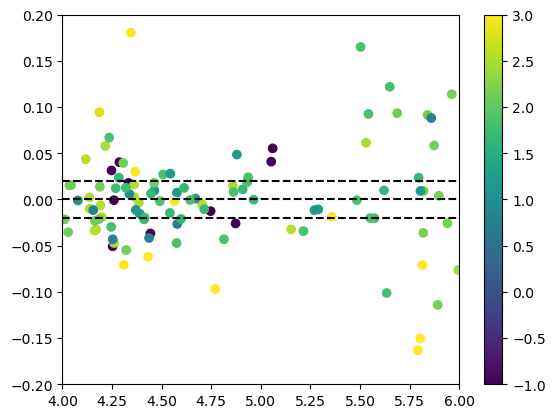

In [45]:
#Cycle through the files in this directory and plot the residuals

files = os.listdir()
os.chdir('/hpc/home/cfm37/RomanASP')

mags = []
residuals = []

#cd into results
os.chdir('./results')
files = os.listdir()
print(files)
allresiduals = []
for f in files:
    if 'detections' in f:
        print('----')
        

        residuals = pd.read_csv(f)
        print(residuals['confusion_metric'])


        mag_residual = -2.5*np.log10(residuals['measured_flux']) +2.5 * np.log10(residuals['realized flux'])
        ID = f.split('_')[0]
        plt.scatter(14 - 2.5*np.log10(residuals['realized flux']), mag_residual, marker = 'o', label = ID, c = np.log10(residuals['confusion_metric']), vmin = -1, vmax = 3)
        #plt.text(14 - 2.5*np.log10(residuals['realized flux'][0]), np.max(np.abs(mag_residual)), str(residuals['id'][0]))
        print(ID)
        allresiduals.extend(mag_residual)





#plt.legend()
plt.axhline(0, color = 'k', ls = '--')
plt.axhline(0.02, color = 'k', ls = '--')
plt.axhline(-0.02, color = 'k', ls = '--')
plt.xlim(4,6)
plt.ylim(-0.2,0.2)
plt.colorbar()
print(np.nanmean(allresiduals))
print(np.nanstd(allresiduals))


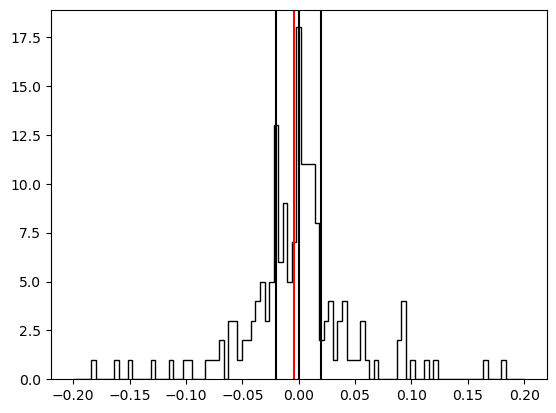

In [50]:
plt.hist(allresiduals, bins = np.linspace(-0.2,0.2,100), histtype = 'step', color = 'k')
plt.axvline(np.nanmean(allresiduals), color = 'r')
plt.axvline(0, color = 'k')
plt.axvline(20/1000, color = 'k')
plt.axvline(-20/1000, color = 'k')

['30666595_Y106_detections.csv', '40084671_Y106_detections.csv', '60144043_Y106_detections.csv', '50010393_Y106_detections.csv', '40120913_Y106_detections.csv', '50134575_Y106_detections.csv', '50061540_Y106_detections.csv', '40018655_Y106_detections.csv', '50129236_Y106_detections.csv', '30000921_Y106_detections.csv', '50049302_Y106_detections.csv', '50099064_Y106_detections.csv', '50027278_Y106_detections.csv', '20170506_Y106_detections.csv', '50022453_Y106_detections.csv', '50144007_Y106_detections.csv', '20055347_Y106_detections.csv', '50106142_Y106_detections.csv', '50123776_Y106_detections.csv']
----
0    143.647072
1    143.647072
2    143.647072
3    143.647072
4    143.647072
5    143.647072
6    143.647072
7    143.647072
8    143.647072
9    143.647072
Name: confusion_metric, dtype: float64
30666595
----
0    0.099016
1    0.099016
2    0.099016
3    0.099016
4    0.099016
5    0.099016
6    0.099016
7    0.099016
8    0.099016
9    0.099016
Name: confusion_metric, dtype: fl

/hpc/home/cfm37/miniconda3/envs/ColeRoman/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


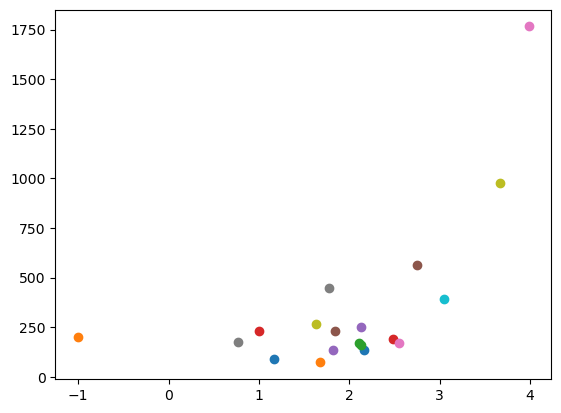

In [57]:
#Cycle through the files in this directory and plot the residuals

files = os.listdir()
os.chdir('/hpc/home/cfm37/RomanASP')

mags = []
residuals = []

#cd into results
os.chdir('./results')
files = os.listdir()
print(files)
allresiduals = []
for f in files:
    if 'detections' in f:
        print('----')
        

        residuals = pd.read_csv(f)
        print(residuals['confusion_metric'])


        mag_residual = -2.5*np.log10(residuals['measured_flux']) +2.5 * np.log10(residuals['realized flux'])
        flux_residual = residuals['measured_flux'] - residuals['realized flux']
        ID = f.split('_')[0]
        std = np.nanstd(mag_residual)
        std = np.nanstd(flux_residual)
        bias = np.nanmean(mag_residual) 
        plt.scatter(np.log10(residuals['confusion_metric'][0]), std, marker = 'o', label = ID)
        #plt.text(14 - 2.5*np.log10(residuals['realized flux'][0]), np.max(np.abs(mag_residual)), str(residuals['id'][0]))
        print(ID)
        allresiduals.extend(mag_residual)





62563.93689999999 2.691369873015799
Overall Bias: 2.21 mmag 
Overall Scatter: 7.56 mmag
[73494. 92483. 78323.  7447. 92128. 77904. 87948.  7805. 87040. 92780.]
[73561.19761362 92353.15396842 77736.59888761  7360.56341212
 91793.70911236 77909.86284167 89134.51014008  7717.86899426
 86864.28930647 93032.10255482]


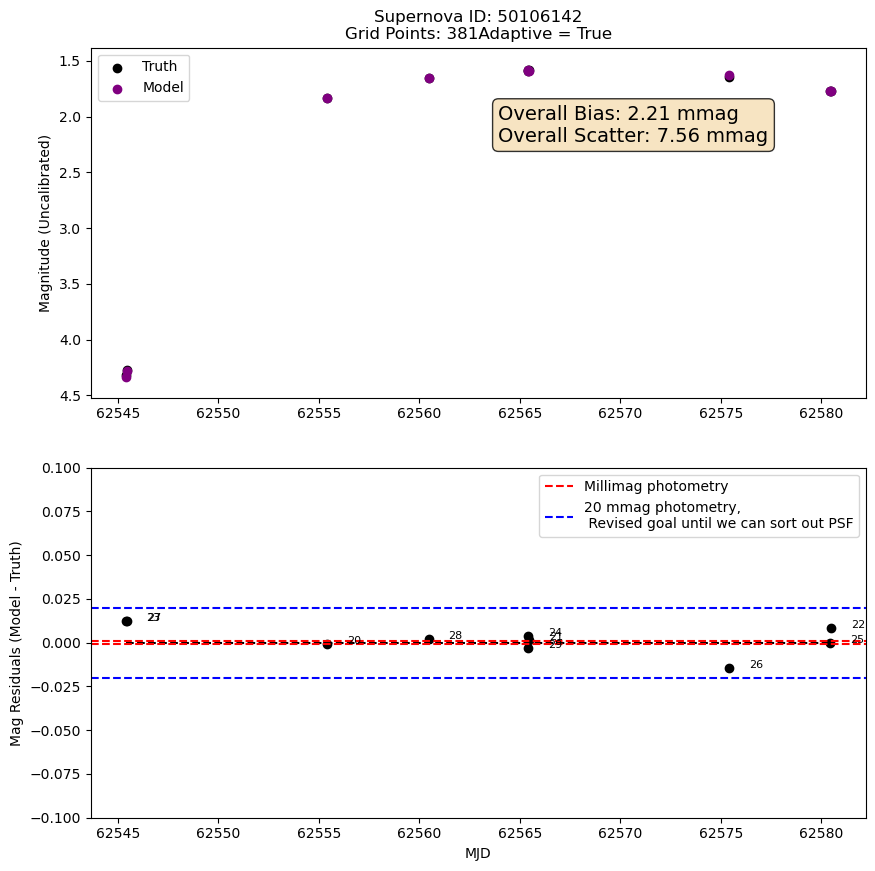

In [11]:
#Plot the lightcurve we found.



if use_real_images:
    supernova = np.array(exposures['realized flux'][np.where(exposures['DETECTED'])])
else:
    supernova = np.array(supernova)


plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
if use_real_images:
    plt.title('Supernova ID: ' + str(ID) + '\n' + 'Grid Points: ' + str(np.size(ra_grid)) + 'Adaptive = ' + str(adaptive_grid))
    dates = exposures['date'][np.where(exposures['DETECTED'])]
else:
    dates = np.arange(detim)
    plt.title('Grid Points: ' + str(np.size(ra_grid)) + 'Adaptive = ' + str(adaptive_grid))


plt.scatter(dates, 14-2.5*np.log10(supernova), color = 'k', label = 'Truth')
plt.scatter(dates, 14-2.5*np.log10(X[-detim:]), color = 'purple', label = 'Model')

plt.ylim(14 - 2.5*np.log10(np.min(supernova)) + 0.2, 14 - 2.5*np.log10(np.max(supernova)) - 0.2)
plt.ylabel('Magnitude (Uncalibrated)')


bias = np.mean(-2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova)))
bias *= 1000
bias = np.round(bias, 2)
scatter = np.std(-2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova)))
scatter *= 1000
scatter = np.round(scatter, 2)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
textstr = 'Overall Bias: ' + str(bias) + ' mmag \n' + \
    'Overall Scatter: ' + str(scatter) + ' mmag'
plt.text(np.mean(dates), 14 - 2.5*np.log10(np.mean(supernova)), textstr,  fontsize=14,
        verticalalignment='top', bbox=props)
print(np.mean(dates), 14 - 2.5*np.log10(np.mean(supernova)) + .8)
print(textstr)
plt.legend()

print(supernova)
print(X[-detim:])

plt.subplot(2,1,2)

flux_mode = False
if flux_mode:
    plt.scatter(dates, X[-detim:] - supernova, color = 'k')
    for i,dr in enumerate(zip(dates, X[-detim:] - supernova)):
        d,r = dr
        plt.text(d+1,r,i+testnum-detim, fontsize = 8)
else:
    plt.scatter(dates, -2.5*np.log10(X[-detim:])+2.5*np.log10(supernova), color = 'k')
    plt.plot([np.min(dates), np.max(dates)], [0,0], ls = '--', color = 'k')
    plt.ylabel('Mag Residuals (Model - Truth)')
    plt.xlabel('MJD')
    plt.ylim(-0.1, 0.1)
    for i,dr in enumerate(zip(dates, -2.5*np.log10(X[-detim:])+2.5*np.log10(supernova))):
        d,r = dr
        plt.text(d+1,r,i+testnum-detim, fontsize = 8)

plt.axhline(0.001, color = 'r', ls = '--')
plt.axhline(-0.001, color = 'r', ls = '--', label = 'Millimag photometry')

plt.axhline(0.02, color = 'b', ls = '--')
plt.axhline(-0.02, color = 'b', ls = '--', label = '20 mmag photometry, \n Revised goal until we can sort out PSF')



plt.legend()


6.271172244161448 5.696681754470774
multiplying by weights
multiplying by weights
BIAS 926.2293076265727
STD 1862.7382199566175
5.7977774342368775 5.3504630285667645
multiplying by weights
multiplying by weights
BIAS 640.6818925287268
STD 1796.1404803154526
6.188077143323426 5.621988265500477
multiplying by weights
multiplying by weights
BIAS 808.2339723813878
STD 1795.602638303645
5.4662348116153225 5.7901961694522015
multiplying by weights
multiplying by weights
BIAS 848.2978972533518
STD 1953.495332017599
5.532063734856365 5.24482540768895
multiplying by weights
multiplying by weights
BIAS 963.1830981412423
STD 2244.6843887518116
4.989997699896094 5.434896960375454
multiplying by weights
multiplying by weights
BIAS 1357.8383988299306
STD 2335.53823414114
5.53859347390744 5.832038162247613
multiplying by weights
multiplying by weights
BIAS 960.8164090586058
STD 2060.6569670972044
5.686517695072098 6.40172106518844
multiplying by weights
multiplying by weights
BIAS 936.2385580328548
S

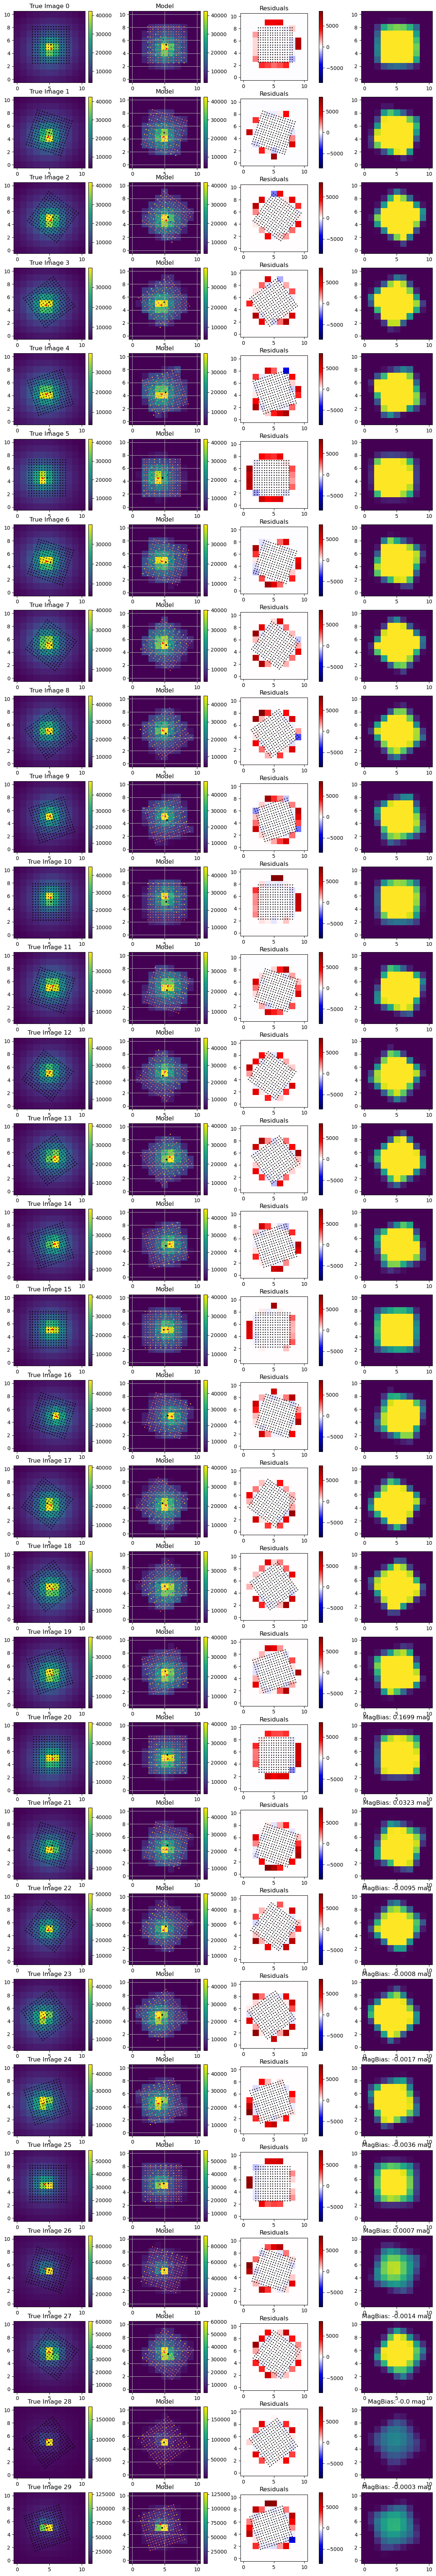

In [39]:
biases = []

fig = plt.figure(figsize = (15,3*testnum))



pred = X * psf_matrix




sumimages = np.sum(pred, axis = 1)
if make_initial_guess and testnum - detim != 0:
    pred0 = x0test.flatten() * psf_matrix
    sumimages0 = np.sum(pred0, axis = 1)
if detim > 0:
    magresiduals = -2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova))

galxes = []
stds = []
biases = []

for i, wcs in enumerate(cutout_wcs_list):

    extent = [-0.5, size-0.5, -0.5, size-0.5]
    if type(wcs) == galsim.fitswcs.AstropyWCS:
        galx, galy = wcs.toImage(galra, galdec, units='deg')
        xx, yy = cutout_wcs_list[i].toImage(ra_grid, dec_grid,units='deg')
    else:
        galx, galy = cutout_wcs_list[i].world_to_pixel(SkyCoord(ra = galra*u.degree, dec = galdec*u.degree))
        xx, yy = cutout_wcs_list[i].world_to_pixel(SkyCoord(ra = ra_grid*u.degree, dec = dec_grid*u.degree))
        

    xx -= 1
    yy -= 1


   
    snx, sny = wcs.toImage(snra, sndec, units = 'deg')
    
    plt.subplot(len(cutout_wcs_list), 4, 4*i+1)
    plt.scatter(xx, yy, color = 'k', s = 1)
    plt.title('True Image ' + str(i))
    plt.scatter(snx-1, sny-1, c = 'k', s = 8, marker = '*')
    print(galx,galy)
    plt.scatter(galx-1,galy-1, c = 'r', s = 8, marker = '*')
    plt.imshow(images[i*size**2:(i+1)*size**2].reshape(size,size), origin = 'lower', extent = extent)
    plt.colorbar(fraction=0.046, pad=0.04)
    trueimage = images[i*size**2:(i+1)*size**2].reshape(size,size)

    '''
    
    argsort = np.argsort(trueimage.flatten())
    brightest = argsort[-5:]
    print(brightest)
    print('Brightest pixels in image', trueimage.flatten()[brightest])
    for k in range(5):
        #label each point with its value

        xbright = brightest[k]%size
        ybright = brightest[k]//size
        xmod = (xbright - 5)
        ymod = (ybright - 5)

        plt.text(xbright + xmod,ybright + ymod, str(np.round(trueimage.flatten()[brightest][k],0)), fontsize = 8, color = 'C'+str(k))
        plt.scatter(brightest[k]%size, brightest[k]//size, color = 'C'+str(k), s = 10)
    '''

    ############################################

    plt.subplot(len(cutout_wcs_list), 4, 4*i+2)
    plt.title('Model')
    
    im1 = sumimages[i*size**2:(i+1)*size**2].reshape(size,size)
    if type(cutout_wcs_list[i]) == galsim.fitswcs.AstropyWCS:
        xx, yy = cutout_wcs_list[i].toImage(ra_grid, dec_grid,units='deg')
    else:
        xx, yy = cutout_wcs_list[i].world_to_pixel(SkyCoord(ra = ra_grid*u.degree, dec = dec_grid*u.degree))

    xx -= 1
    yy -= 1

    if weighting:
        print('multiplying by weights')
        
    vmin = np.min(images[i*size**2:(i+1)*size**2].reshape(size,size))
    vmax = np.max(images[i*size**2:(i+1)*size**2].reshape(size,size))

    if weighting:
        im1[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) == 0)] = 0
    plt.imshow(im1, extent = extent, origin = 'lower', vmin = vmin, vmax = vmax)
    plt.colorbar(fraction=0.046, pad=0.04)
    

    if fit_background:
        plt.scatter(xx,yy, c = X[:np.size(ra_grid)], cmap = 'plasma', s = 1)
    elif not single_grid_point:
        if detim != 0:
            plt.scatter(xx,yy, c = X[:-testnum], cmap = 'plasma', s = 1)
        else:
            plt.scatter(xx,yy, c = X, cmap = 'plasma', s = 1)

    
    
    plt.scatter(galx-1,galy-1, c = 'r', s = 8, marker = '*')
    plt.scatter(snx-1, sny-1, c = 'k', s = 8, marker = '*')

    #plt.xlim(-1,size)
    #plt.ylim(-1,size)
    plt.grid(True, which = 'both')
    
    ############################################
    plt.subplot(len(cutout_wcs_list),4,4*i+3)
    plt.title('Residuals')
    plt.scatter(xx,yy,color = 'k', s = 1)
    res = images - sumimages
    if weighting:
        print('multiplying by weights')
        #res*=wgt_matrix
        
        
    current_res= res[i*size**2:(i+1)*size**2].reshape(size,size)
    if weighting:
        current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) == 0)] = 0
        print('BIAS', np.mean(current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) != 0)]))
        biases.append(np.mean(current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) != 0)]))
        print('STD', np.std(current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) != 0)]))

    galxes.append(galx)
    biases.append(np.mean(current_res))
    stds.append(np.std(current_res))
    if i == 0:
        norm = np.max(np.abs(res[np.where(wgt_matrix != 0)]))
    #norm = 1

    plt.imshow(current_res, extent = extent, origin = 'lower', cmap = 'seismic', vmin = -norm, vmax = norm)
    #plt.imshow(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size), extent = extent, origin = 'lower')
    plt.colorbar(fraction=0.046, pad=0.14)
    #plt.scatter(galx,galy, c = 'r', s = 12, marker = '*', edgecolors='k')
    

    ############################################
    plt.subplot(len(cutout_wcs_list),4,4*i+4)
    #plt.hist(trueimage.flatten(), bins = np.linspace(-50,50,20), histtype = 'step', color = 'k', density = True)
    
    if i >= testnum - detim:
        plt.title('MagBias: ' + str(np.round(magresiduals[i - testnum + detim],4)) + ' mag')

    im1_guess = sumimages0[i*size**2:(i+1)*size**2].reshape(size,size)
    plt.imshow(im1_guess, extent = extent, origin = 'lower', vmin = vmin, vmax = vmax)
    
    #plt.hist(current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) != 0)], bins = np.linspace(-norm/2,norm/2,30), histtype = 'step', color = 'k', density = True)
    #plt.axvline(np.mean(trueimage.flatten()[np.where(trueimage.flatten()< 50)]), color = 'r')
    '''
    justbgX = np.copy(X)
    justbgX[-testnum:] = 0

    justbgpred = justbgX * psf_matrix
    justbgsumimages = np.sum(justbgpred, axis = 1)
    justbgim = justbgsumimages[i*size**2:(i+1)*size**2].reshape(size,size)
    

    #subtract off the real sn
    #if i >= testnum - detim:
        #print('subtracting sn')
        #justbgim -= sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*supernova[i - testnum + detim]
    


    
    #get the 5 brightest pixels in the image
    justbgres = trueimage - justbgim
    im1 = sumimages[i*size**2:(i+1)*size**2].reshape(size,size)


    plt.plot(trueimage[5], label = 'Image')
    plt.plot(im1[5], label = 'Model')
    plt.plot(justbgim[5], label = 'Background Only')
    plt.plot(justbgres[5], label = 'Image Background Subtracted')
    
    if i >= testnum - detim:
        snim = sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*supernova[i - testnum + detim]
        print('multiplying by ', supernova[i - testnum + detim])
    else:
        snim = np.zeros_like(justbgres)


    plt.plot(snim[5], label = 'Perfect Supernova')
    plt.axvline(snx-1+1, ls = '--', color = 'k')
    plt.axvline(snx-1-1, ls = '--', color = 'k')
    if i >= testnum - 1 or i == 0:
        plt.legend()
    
    #plt.imshow(justbgres, extent = extent, origin = 'lower', vmin = -200, vmax = 200)
    #plt.colorbar(fraction=0.046, pad=0.04)
    '''
 

plt.subplots_adjust(wspace = 0.4)

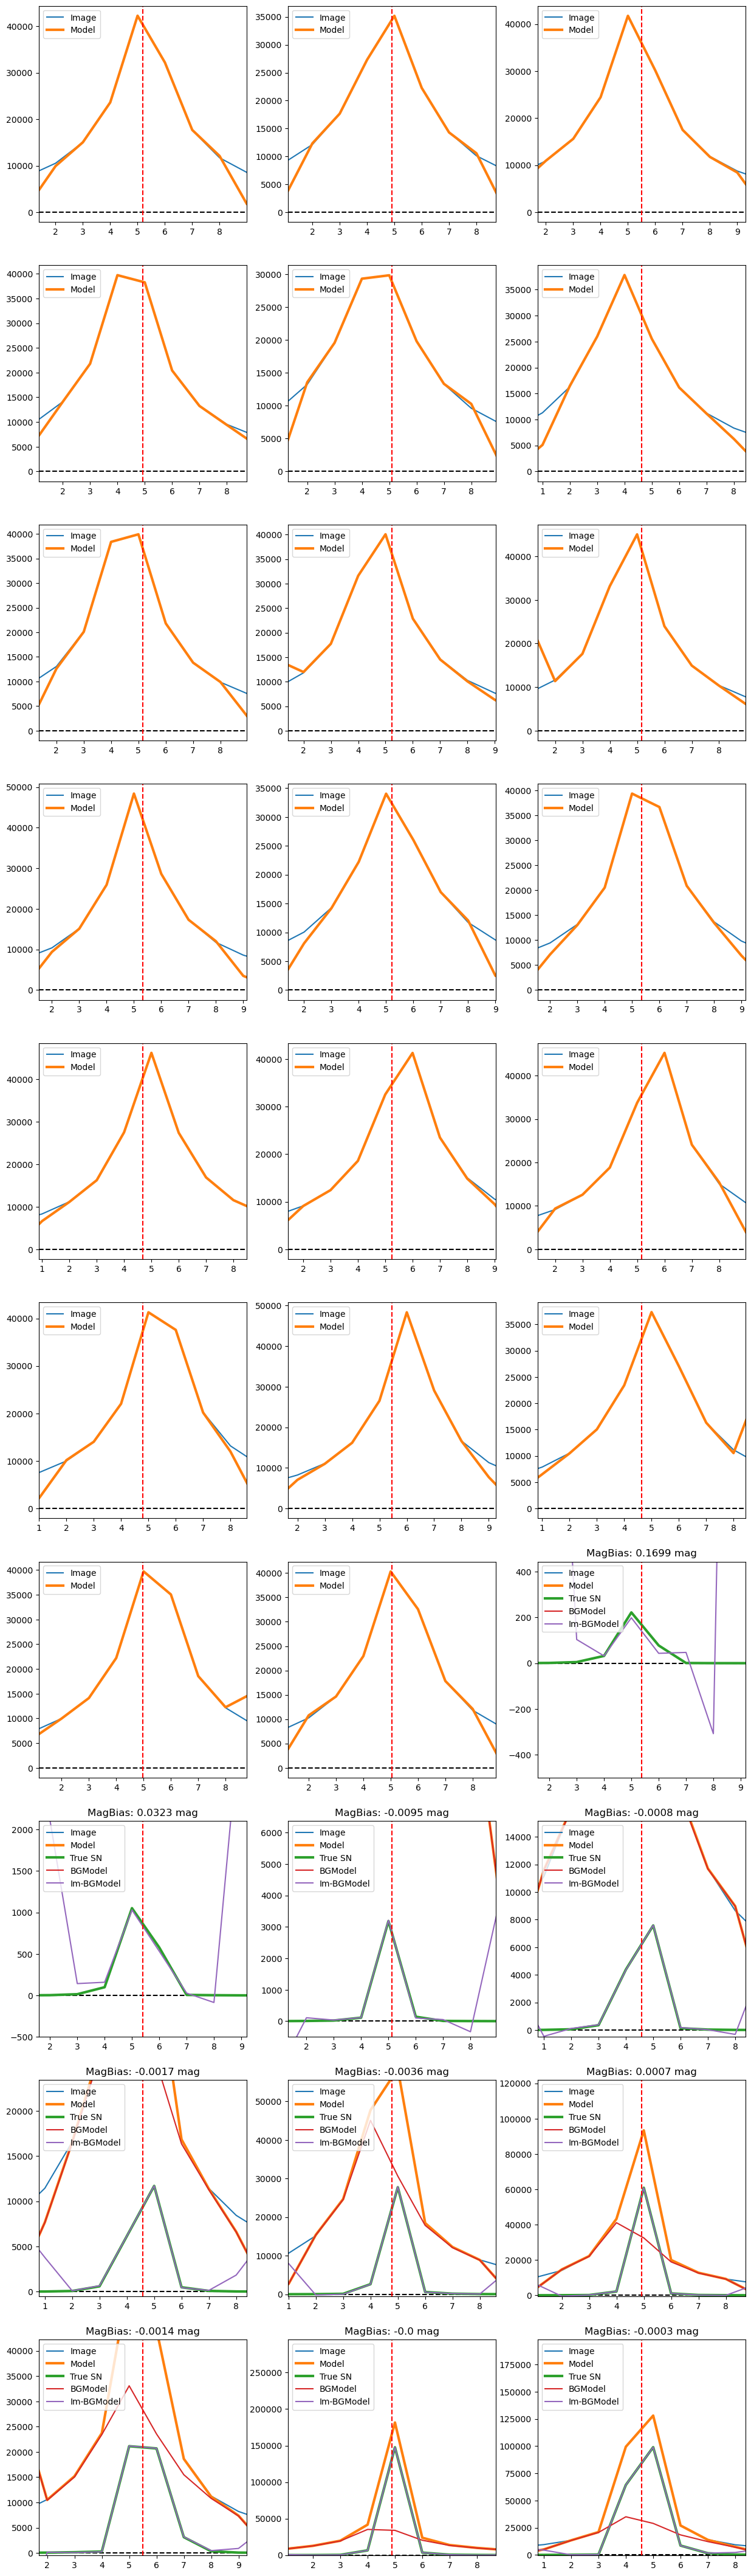

In [38]:
biases = []
fig = plt.figure(figsize = (15,2*testnum))


#realSNX = np.copy(X)
#
# NX[-detim:] = supernova
#X = np.zeros_like(X)
#X[50] = 500000
pred = X * psf_matrix
#print(pred[50])
#print('setting X to 0 as A TEST AAAAAAAAAAAAAAAAAACJDABHSLJFNSJDF')

centralpixel_model = []
centralpixel_image = []


sumimages = np.sum(pred, axis = 1)
if make_initial_guess and testnum - detim != 0:
    pred0 = x0test.flatten() * psf_matrix
    sumimages0 = np.sum(pred0, axis = 1)

if detim > 0:
    magresiduals = -2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova))

galxes = []
stds = []
biases = []

for i, wcs in enumerate(cutout_wcs_list):

    extent = [-0.5, size-0.5, -0.5, size-0.5]
    trueimage = images[i*size**2:(i+1)*size**2].reshape(size,size)
    snx, sny = wcs.toImage(snra, sndec, units = 'deg')

    plt.subplot(len(cutout_wcs_list)//3 + 1,3,i+1)
    if i >= testnum - detim:
        plt.title('MagBias: ' + str(np.round(magresiduals[i - testnum + detim],4)) + ' mag')


    justbgX = np.copy(X)
    justbgX[-testnum:] = 0

    justbgpred = justbgX * psf_matrix
    justbgsumimages = np.sum(justbgpred, axis = 1)
    justbgim = justbgsumimages[i*size**2:(i+1)*size**2].reshape(size,size)
    

    #subtract off the real sn
    #if i >= testnum - detim:
        #print('subtracting sn')
        #justbgim -= sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*supernova[i - testnum + detim]
    


    
    justbgres = trueimage - justbgim
    im1 = sumimages[i*size**2:(i+1)*size**2].reshape(size,size)


    plt.plot(trueimage[5], label = 'Image')
    centralpixel_image.append(np.sum(trueimage[5][3:7]))
    plt.axhline(0, ls = '--', color = 'k')
    plt.plot(im1[5], label = 'Model', lw = 3)
    #plt.ylim(-250,250)
    centralpixel_model.append(np.sum(justbgim[5][3:7]))

    
    
    if i >= testnum - detim:
        snim = sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*supernova[i - testnum + detim]
        plt.plot(snim[5], label = 'True SN', lw = 3)
        #plt.plot(trueimage[5] - snim[5], label = 'Im-True SN')
        plt.plot(justbgim[5], label = 'BGModel')
        plt.plot(justbgres[5], label = 'Im-BGModel')
        
        #plt.plot(justbgres[5] - snim[5], label = 'SN Residuals', ls = '--')
        plt.ylim(-500,np.max(snim[5])*2)
        snim = sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*X[-detim:][i - testnum + detim]

    else:
        snim = np.zeros_like(justbgres)


    
    plt.axvline(snx-1+4, ls = '--', color = 'k')
    plt.axvline(snx-1-4, ls = '--', color = 'k')
    plt.axvline(snx-1, ls = '--', color = 'r')

    plt.xlim(snx-1-3.8, snx-1+3.8)


    plt.legend(loc = 'upper left')
    




2288.3301656192034 1425.410828282497
2288.3301656190897 1425.4108282831605
1.1368683772161603e-10 -6.634763849433511e-10


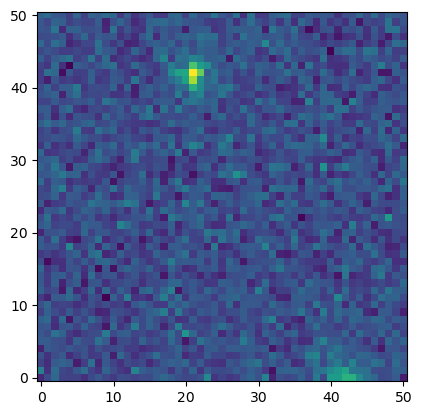

In [157]:
hdu_list = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{SCA}.fits.gz')

image = galsim.fits.read(hdu_list = hdu_list[1])
x,y = image.wcs.toImage(7.6,-44.2, units = 'deg')

print(x,y)


wcs2 = WCS(hdu_list[1])
wcs2 = galsim.AstropyWCS(wcs = wcs2)

#print(wcs2)

x2,y2 = wcs2.toImage(7.6,-44.2, units = 'deg')
print(x2,y2)
print(x-x2, y-y2)

bounds = galsim.BoundsI(int(x - 25), int(x + 25), int(y - 25), int(y + 25))
image = image[bounds]

plt.imshow(image.array, origin = 'lower')
#image.wcs.toImage(7.6,-44.2, units = 'deg')

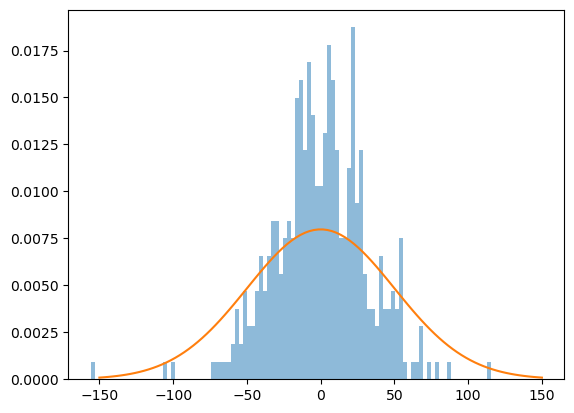

In [14]:
plt.hist((images - sumimages)[np.where(wgt_matrix != 0)], bins = 100, alpha = 0.5, label = 'Residuals', density= True)
#overplot a gaussian
mean = np.mean((images - sumimages)[np.where(wgt_matrix != 0)])
std = 50

x = np.linspace(-3*std,3*std,100)
plt.plot(x, 1/(std*np.sqrt(2*np.pi))*np.exp(-0.5*(x-mean)**2/std**2), label = 'Gaussian Fit')

[40973065058, 40973069056, 40973069056, 40973069437, 40973069007, 40973066659, 41024094797, 40973065671, 40973065671, 41024094247, 40973068488, 40973067254, 40973067779, 40973067105, 40973069150, 40973067291, 41024094391, 40973066222, 40973069174, 41024094751]
917 Potential Candidates
-----------------------
27.63367435233032 zpt
realized flux 22135    16977.0
Name: realized_flux, dtype: float64
measured flux [16592.36923738]
-----------------------
27.597032121020195 zpt
realized flux 22175    16784.0
Name: realized_flux, dtype: float64
measured flux [17000.73411222]
-----------------------
27.655797626691033 zpt
realized flux 21452    16922.0
Name: realized_flux, dtype: float64
measured flux [16981.9788038]
-----------------------
27.61268412018935 zpt
realized flux 22971    17175.0
Name: realized_flux, dtype: float64
measured flux [17814.91282759]
-----------------------
27.661771646441444 zpt
realized flux 22399    17012.0
Name: realized_flux, dtype: float64
measured flux [17185.60

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


27.604242172119765 zpt
realized flux 23252    1235.0
Name: realized_flux, dtype: float64
measured flux [1196.05873751]
STD: 0.030389050986648975
mean: 0.0038649825003746587
ZPT: [27.533757667400266, 27.637947127873026, 27.576451322869843, 27.587881837350075, 27.61000415527048, 27.59811200840697, 27.592451089677805, 27.626146631931398, 27.56095659631211, 27.604242172119765]
Measured: [1169.9514969103652, 1185.2997996835168, 1142.4850681258872, 1088.9767634870846, 1277.7509084935828, 1107.0131215007073, 1176.148800838352, 1202.873474848487, 1287.7409400259733, 1196.0587375096657]
Realized: [1130.0, 1165.0, 1146.0, 1123.0, 1235.0, 1145.0, 1181.0, 1194.0, 1230.0, 1235.0]


<Figure size 500x2500 with 0 Axes>

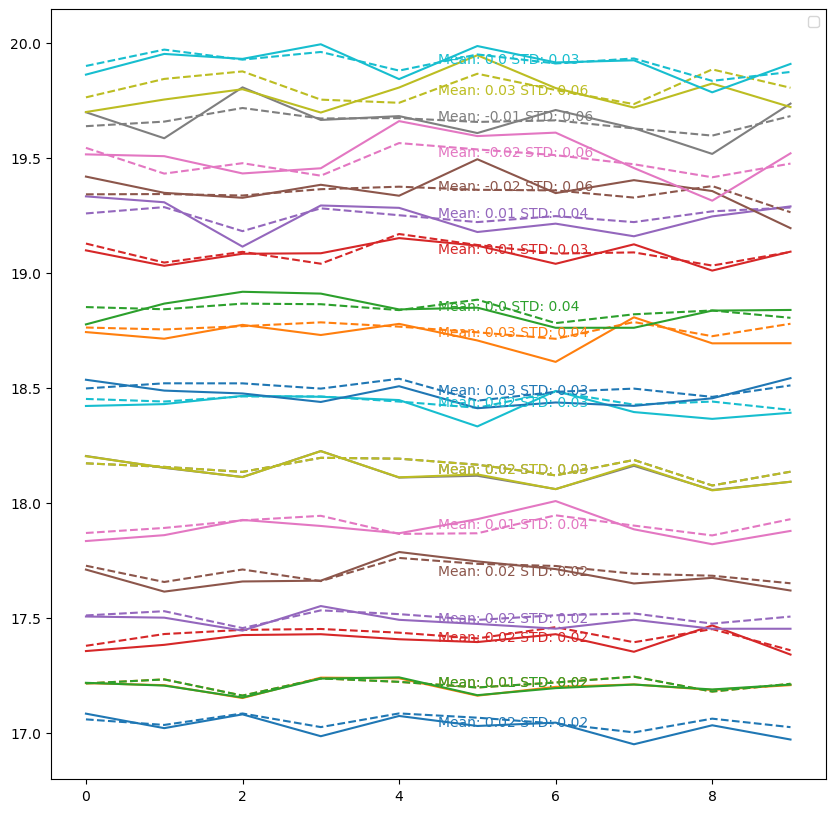

In [10]:
sn_path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/'
plt.figure(figsize = (5,25))
band = 'F184'
pointing, SCA = 13021, 15
cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
cat_star = cat.loc[cat['obj_type'] == 'star']
IDs = []
ras = []
decs = []
for i in np.linspace(4,7,20):
    #print(i)
    #print(np.max(cat_star['mag']), np.min(cat_star['mag']))
    cat_close = cat_star.loc[np.isclose(cat_star['mag'], i, atol = 0.1)]
    IDs.append(cat_close.object_id.values[0])
    ras.append(cat_close.ra.values[0])
    decs.append(cat_close.dec.values[0])


print(IDs)

size = 25  
nbg = -1
plt.figure(figsize = (10,10))
for i, ID in enumerate(IDs):
    ra = ras[i]
    dec = decs[i]
    start = 0
    end = 10**999
    p = pointing
    s = SCA
    peak = 0

    server_url = 'https://roman-desc-simdex.lbl.gov'
    req = requests.Session()
    result = req.post( f'{server_url}/findromanimages/containing=({ra},{dec})' )
    if result.status_code != 200:
        raise RuntimeError( f"Got status code {result.status_code}\n{result.text}" )

    res = pd.DataFrame(result.json())[['filter','pointing','sca', 'mjd']]
    res.rename(columns = {'mjd':'date', 'pointing': 'Pointing', 'sca': 'SCA'}, inplace = True)
    print(res.shape[0], 'Potential Candidates')
    res = res.loc[res['filter'] == band]

    realized_flux = []
    measured_flux = []
    zpts = []
    for index, row in res.iterrows():
        print('-----------------------')
        p = row['Pointing']
        s = row['SCA']
        image = fits.open(roman_path + f'/RomanTDS/images/truth/{band}/{p}/Roman_TDS_truth_{band}_{p}_{s}.fits.gz')
        scawcs = WCS(image[0].header)
        x,y = scawcs.world_to_pixel(SkyCoord(ra = ra*u.degree, dec = dec*u.degree))
        if x < 25 or x > 2*2048 - 25 or y < 25 or y > 2*2048 - 25:
            print('Out of bounds')
            continue

        cutout = Cutout2D(image[0].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)
        cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
        x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')
        psf = construct_psf_source(x, y, pointing, SCA, stampsize=25,  x_center = x_center, y_center = y_center)
        #fit the psf to the image
        im = cutout.data
        #plt.subplot(1,2,1)
        #plt.imshow(im.reshape(25,25), origin = 'lower')
        #plt.grid('True')
        #plt.subplot(1,2,2)
        #plt.imshow(psf.reshape(25,25), origin = 'lower')
        #plt.grid('True')
        im = im.flatten()
        #plt.hist(im, bins = 100)
        psf = psf.flatten()
        psf = psf.reshape(-1,1)
        lsqr = sp.linalg.lsqr(psf, im, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
        cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{p}/Roman_TDS_index_{band}_{p}_{s}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])

        cat_star = cat.loc[cat['obj_type'] == 'star']
        logflux = -2.5*np.log10(cat_star['flux'])
        exptime = image[0].header['EXPTIME']
        area_eff = roman.collecting_area
        galsim_zp = roman.getBandpasses()[band].zeropoint
        truthmag = -2.5*np.log10(cat['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp
        mag = cat_star['mag']


        zpt = np.nanmedian(truthmag)
        print(zpt, 'zpt')
        zpts.append(zpt)

        
        cat = cat.loc[cat['object_id'] == ID]
        print('realized flux', cat['realized_flux'])
        print('measured flux', lsqr[0])

        realized_flux.append(cat['realized_flux'].values[0])
        measured_flux.append(lsqr[0][0])
        #psf = psf.reshape(-1)
        #plt.imshow((im - lsqr[0]*psf).reshape(25,25), origin = 'lower', cmap = 'seismic', vmin = -80, vmax =80)
        #plt.colorbar()
        if len(realized_flux) == 10:
            break

    std = np.std(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))))
    mean = np.mean(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))))
    print('STD:', std)
    print('mean:', mean)
    print('ZPT:', zpts)
    print('Measured:', measured_flux)
    print('Realized:', realized_flux)
    plt.plot(-2.5*np.log10(np.array(realized_flux)) + np.array(zpts), color = 'C' + str(i), ls = '--')
    plt.plot(-2.5*np.log10(np.array(measured_flux)) + np.array(zpts), color = 'C' + str(i))
    plt.text(4.5, np.mean(-2.5*np.log10(np.array(measured_flux)) + np.array(zpts)), 'Mean: ' + str(np.round(mean,2)) + ' STD: ' + str(np.round(std,2)), color = 'C' + str(i)) 
    
        
        

    '''
    test = MultiDetection(ra, dec, p, s, band, start, end, peak, snid = ID, sigma_gaus = 0)
    test.runPhotometry(background = False, err = False, n_grid = nbg, maxbg = 0, maxdet = 10, roman_path = roman_path, \
                  pointing_list = None, SCA_list = None, bare_bones = False, precise = True, size = size)
    realized_flux = test.exposures[test.exposures['DETECTED']]['realized flux']
    truths = -2.5 * np.log10(realized_flux) + test.exposures['zeropoint'][-1]
    residuals = truths - test.mag
    plt.subplot(5,1,i+1)
    plt.plot(residuals, marker = 'o', label = 'realized residual :'+str(test.exposures['true mag'][0]))
    truths = test.exposures[test.exposures['DETECTED']]['true mag']
    residuals = truths - test.mag
    plt.plot(residuals, marker = 'o', label = 'true residual  :'+str(test.exposures['true mag'][0]))
    print('BIAS:', np.mean(residuals))
    #RMS of residuals
    print('RMS:', np.sqrt(np.mean(residuals**2) / np.size(residuals)))
    plt.plot(np.zeros(np.size(residuals)), label = 'Zeroline', color = 'k', ls = '--')
    plt.plot(np.zeros(np.size(residuals))+0.01, color = 'k', ls = '--')
    plt.plot(np.zeros(np.size(residuals))-0.01, color = 'k', ls = '--')
    plt.legend()



plt.show()
'''
plt.legend()
    

In [10]:
sn_path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/'
plt.figure(figsize = (7,7))
band = 'J129'

realized_flux = []
measured_flux = []

for SCA in range(1,19):
    if len(realized_flux) == 200:
            break
    print('Switching to SCA ', SCA)

    pointing = 17139
    size = 25
    cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                    sep="\s+", skiprows = 1,
                                    names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
    cat_star = cat.loc[cat['obj_type'] == 'star']
    cat_star = cat_star.loc[cat_star['mag'] < 7]
    cat_star = cat_star.loc[cat_star['mag'] > 0]
    print(np.size(cat_star['flux']))

    image = fits.open(roman_path + f'/RomanTDS/images/truth/{band}/{pointing}/Roman_TDS_truth_{band}_{pointing}_{SCA}.fits.gz')
    scawcs = WCS(image[0].header)



    for i, row in cat_star.iterrows():
        print(i, row['mag'])
        ra = row['ra']
        dec = row['dec']
        x,y = scawcs.world_to_pixel(SkyCoord(ra = ra*u.degree, dec = dec*u.degree))
        if x < 25 or x > 2*2048 - 25 or y < 25 or y > 2*2048 - 25:
            print('Out of bounds')
            continue
        cutout = Cutout2D(image[0].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)
        cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
        x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')
        psf = construct_psf_source(x, y, pointing, SCA, stampsize=25,  x_center = x_center, y_center = y_center)
        #fit the psf to the image
        im = cutout.data
        im = im.flatten()
        psf = psf.flatten()
        psf = psf.reshape(-1,1)
        lsqr = sp.linalg.lsqr(psf, im, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
        realized_flux.append(row['realized_flux'])
        measured_flux.append(lsqr[0][0])
        if len(realized_flux) == 200:
            break




    

Switching to SCA  1
206


26276 2.52174962
Out of bounds
26277 5.43560883
Out of bounds
26279 3.02409617
Out of bounds
26280 5.5273891
Out of bounds
26281 3.99046116
Out of bounds
26282 6.47232372
Out of bounds
26283 6.46442496
Out of bounds
26284 6.33455005
Out of bounds
26285 3.92413831
Out of bounds
26287 1.0574761
26288 1.69848274
Out of bounds
26289 5.34092442
26290 4.9609241
Out of bounds
26293 4.86077188
Out of bounds
26294 2.39112966
Out of bounds
26296 6.70298796
Out of bounds
26297 6.00747657
Out of bounds
26298 5.12900468
Out of bounds
26299 6.50032178
Out of bounds
26300 2.29591433
26302 5.65322519
Out of bounds
26303 5.78472371
26304 5.38919412
Out of bounds
26305 6.23263468
Out of bounds
26307 3.89451774
Out of bounds
26309 0.316713028
Out of bounds
26311 1.16452141
Out of bounds
26312 5.21583507
Out of bounds
26313 2.3797222
Out of bounds
26314 5.89937135
26315 6.06458374
26316 4.79624581
26317 6.16732255
26318 3.90711443
Out of bounds
26320 6.17582475
Out of bounds
26321 0.705542526
Out of bound

<Figure size 700x700 with 0 Axes>

32.67773385206138
[-0.01546948 -0.00377081 -0.01754705 -0.01532871 -0.00428948 -0.01021828
 -0.00574206 -0.00730096 -0.00548198 -0.00408703 -0.00230382  0.0016047
 -0.00782975 -0.0013105  -0.00399156 -0.00339771  0.0053254  -0.00675236
 -0.00051265  0.00052847 -0.00920958 -0.01210535 -0.0065299   0.00675026
 -0.00062931 -0.0050826  -0.01440228 -0.00130655]
0.005892707919112801


(-0.1, 0.1)

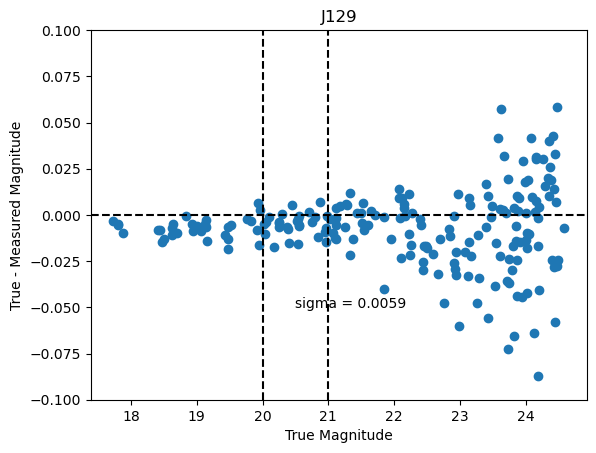

In [11]:
realized_mag = -2.5*np.log10(np.array(realized_flux))
measured_mag = -2.5*np.log10(np.array(measured_flux))
cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
cat_star = cat.loc[cat['obj_type'] == 'star']

exptime = image[0].header['EXPTIME']
area_eff = roman.collecting_area
galsim_zp = roman.getBandpasses()[band].zeropoint
truthmag = -2.5*np.log10(cat['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp
mag = cat_star['mag']
logflux = -2.5*np.log10(cat_star['flux'])
zpt = np.nanmedian(truthmag - logflux)
#truthmag = truthmag - zpt
# - np.median(truthmag)
#zpt = np.nanmedian(truthmag)
print(zpt)
plt.scatter(realized_mag + zpt, realized_mag - measured_mag)
plt.xlabel('True Magnitude')
plt.ylabel('True - Measured Magnitude')
plt.axvline(20, color = 'k', ls = '--')
plt.axvline(21, color = 'k', ls = '--')
plt.axhline(0, color = 'k', ls = '--')
residuals = realized_mag - measured_mag

residuals = residuals[np.where((realized_mag + zpt < 21) & (realized_mag + zpt > 20))]
print(residuals)
print(np.nanstd(residuals))
plt.text(20.5, -0.05, 'sigma = ' + str(np.round(np.nanstd(residuals),4)))
plt.title(band)
plt.ylim(-0.1,0.1)

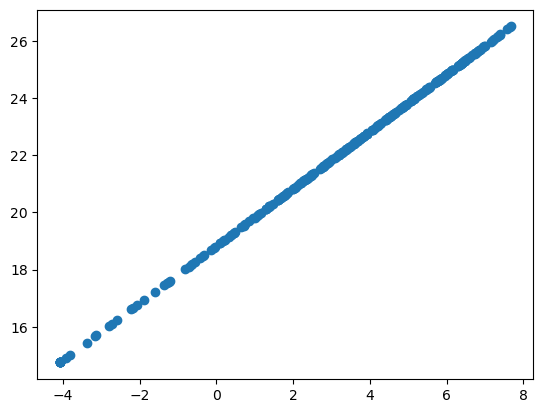

In [22]:
plt.scatter(cat_star['mag'], -2.5*np.log10(cat_star['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp)

In [6]:
df = open_parq(10430, path = sn_path)
reals = df.loc[(df.peak_mjd < 62800.0)]
reals = reals.loc[(df.peak_mjd > 62400.0)]
reals = reals.loc[reals.host_mag_F < 999]
#reals = reals.loc[reals.ra > 6.487]
reals = reals.loc[reals.ra > 7]
#reals = reals.loc[reals.ra < 12.51]
reals = reals.loc[reals.ra < 8]
#reals = reals.loc[reals.dec > -46.877]
reals = reals.loc[reals.dec > -45]
#reals = reals.loc[reals.dec < -41.124]
reals = reals.loc[reals.dec < -44]
df = reals
df = df.sort_values('peak_mag_F')
print(list(df.id[4:28]))

[50134575, 50022453, 40018655, 20055347, 50027278, 50144007, 40084671, 50070195, 50071618, 40120913, 50065247, 50061540, 60144043, 50118342, 50119066, 50123776, 50049302, 50010393, 40096456, 50093469, 50099064, 20170506, 30666595, 30201096]


In [29]:
biases = []
stds = []




roman_bandpasses = galsim.roman.getBandpasses()



galwcs2 = None
ra_max = None
###################### BEGIN TEST PARAMETERS #######################
band = 'F184'
npoints = 7
size = 11
testnum = 30 #Total number of images
detim = 15  #Number of images with a supernova

#PSF for when not using the Roman PSF
lam = 1293  # nm
lam_over_diam = 0.11300864172775239   #This is the roman value
airy = galsim.ChromaticOpticalPSF(lam, diam = 2.36, aberrations=galsim.roman.getPSF(1,band, pupil_bin = 1).aberrations)

use_real_images = True
use_roman = True

# These are only for my simulated images # 
check_perfection = False #Don't bother with these five
make_exact = False
avoid_non_linearity = False
deltafcn_profile = False 
single_grid_point = False 


do_xshift = True    #whether to shift the images in the x direction (they will still be centered on the same point, this is just to emulate\
        #Roman taking a series of images at different locations.)
do_rotation = True #whether to rotate the images
noise = 50 #Standard Deviation of noise to add to a simulated image. 
background_level = 300  #mean of the noise to add to the image
if detim == 0:
    supernova = 0
else:
    d = np.linspace(5,20,detim)
    mags = -5 * np.exp(-d/10) + 6
    fluxes = 10**(mags)
    supernova = list(fluxes)   #This is my faux lightcurve, you can edit this if you want to test with a different lightcurve.
#########################################


make_initial_guess = False  #Make an initial guess for the grid point values by averaging over pixels
adaptive_grid = True       #Use my new adaptive grid method rather than a static evenly spaced grid. Bizarrely, this seems to be worse
                            #when just fitting background, but gives better results when fitting for the supernova flux.


fit_background = False     #If true, each image will have a new parameter introduced with it that fits for the background. If False
                            #the background will be subtracted from the images before fitting based on the background level over the whole image.
                            #So far, I've found keeping this to be False is better.

weighting = True #Apply a weighting to the fit. Currently, this is a tophat of radius 4 pix around the SN location. 
                #I've been experimenting with including a Gaussian on top of this.



if single_grid_point:
    assert make_exact
if avoid_non_linearity:
    assert deltafcn_profile
assert detim <= testnum
if type(supernova) == 'list':
    assert len(supernova) == detim

method = 'lsqr'  #Fitting method used at the end of the algorithm. LSQR is by far the best I need to remove this option. 

galsim.roman.roman_psfs._make_aperture.clear() #clear cache

sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                                wave_type='nm', flux_type='fphotons')

###################### END TEST PARAMETERS #######################

#10430
df = open_parq(10430, path = sn_path)
reals = df.loc[(df.peak_mjd < 62800.0)]
reals = reals.loc[(df.peak_mjd > 62400.0)]
reals = reals.loc[reals.host_mag_F < 999]
#reals = reals.loc[reals.ra > 6.487]
reals = reals.loc[reals.ra > 7]
#reals = reals.loc[reals.ra < 12.51]
reals = reals.loc[reals.ra < 8]
#reals = reals.loc[reals.dec > -46.877]
reals = reals.loc[reals.dec > -45]
#reals = reals.loc[reals.dec < -41.124]
reals = reals.loc[reals.dec < -44]
df = reals
df = df.sort_values('peak_mag_F')
for ID in df.id:
    print('starting SN ', ID)

    #Check if the file already exists
    if os.path.exists(f'./residuals_minortweaks_{str(ID)}.csv'):
        print('already completed' + str(ID))
        continue
    

    ################### Finding and Preparing Images Section #########
    psf_matrix = []
    imagelist = []
    wgt_matrix = []
    sn_matrix = []
    cutout_wcs_list = []
    im_wcs_list = []
    gridmade = False

    #This is a catch for when I'm doing my own simulated WCS's
    image = None
    util_ref = None

    #try
    if use_real_images:

        #Find SN Info, find exposures containig it, and load those as images. 
        pqfile = find_parq(ID, sn_path)
        ra, dec, p, s, start, end, peak, galra, galdec = \
            SNID_to_loc(ID, pqfile, date = True, band = band, snpath = sn_path, roman_path = roman_path, host = True)
        snra = ra
        sndec = dec
        start = start[0]
        end = end[0]
        exposures = findAllExposures(ID, ra,dec, peak,start,end, roman_path=roman_path, maxbg = testnum - detim, \
            maxdet = detim, return_list = True, band = band)
        if len(exposures) != testnum:
            print('Not enough exposures')
            continue

        images, cutout_wcs_list, im_wcs_list, err = constructImages(exposures, ra, dec, size = size, \
            background = fit_background, roman_path = roman_path)
        print(images)
        imlist = [images[i*size**2:(i+1)*size**2].reshape(size,size) for i in range(testnum)]

    else:
        #Simulate the images of the SN and galaxy.
        ra, dec = 7.541534306163982, -44.219205940734625
        snra = ra
        sndec = dec
        galra = ra + 1.5e-5
        galdec = dec + 1.5e-5
        print(snra,sndec,galra,galdec, 'SN AND GAL COORDINATES')

        images, im_wcs_list, cutout_wcs_list = simulateImages(testnum,detim,ra,dec,do_xshift,\
            do_rotation,supernova,noise = noise,use_roman=use_roman, size = size)
        imlist = [images[i*size**2:(i+1)*size**2].reshape(size,size) for i in range(testnum)]




    #If not using the adaptive grid, make a grid of points to fit over.
    if not adaptive_grid:
        if single_grid_point:
            ra_grid, dec_grid = [ra], [dec]
        else:
            ra_grid, dec_grid = local_grid(ra,dec, cutout_wcs_list[0], npoints, size = size, spacing = 0.75, spline_grid = False)
            #print('Using gradient grid!!!!!')
            #ra_grid, dec_grid = gradientGrid(images[0*size**2:(0+1)*size**2].reshape(size,size), cutout_wcs_list[0], ra_grid, dec_grid)
        if make_exact:
            if single_grid_point:
                galra = ra_grid[0]
                galdec = dec_grid[0]
            else:
                galra = ra_grid[106]
                galdec = dec_grid[106]

            
        ra_grid = np.array(ra_grid)
        dec_grid = np.array(dec_grid)
        gridmade = True

    #Apply the weighting mask to the images.
    if weighting:
        for i in range(testnum):
            xx, yy = np.meshgrid(np.arange(0,size,1), np.arange(0,size,1))
            xx = xx.flatten()
            yy = yy.flatten()
            rara, decdec = cutout_wcs_list[i].toWorld(xx, yy, units = 'deg')
            dist = np.sqrt((rara - snra)**2 + (decdec - sndec)**2)

            if use_real_images:
                error = err[i*size**2:(i+1)*size**2]

            snx, sny = cutout_wcs_list[i].toImage(snra, sndec, units = 'deg')
            dist = np.sqrt((xx - snx + 1)**2 + (yy - sny + 1)**2)
            #wgt = np.zeros(size**2)
            wgt = np.ones(size**2)
            

            wgt = 5*np.exp(-dist**2/2.5)
            print('using a gaussian weighting of 2.5')
            wgt[np.where(dist > 4)] = 0

            if use_real_images:
                wgt /= error
            wgt = wgt / np.sum(wgt)
            wgt_matrix.append(wgt)

    #If instead making an adaptive grid, use the weighted images to inform where grid points
    #should be placed.
    if adaptive_grid:
        a = images[:size**2].reshape(size,size)
        if weighting:
            wgt = wgt_matrix[0]
        else:
            wgt = np.ones_like(a)
            
        ra_grid, dec_grid = local_grid(ra,dec, cutout_wcs_list[0], \
                npoints, size = size,  spacing = 0.75, image = a, spline_grid = False)
        print('removed wgt when making adaptive grid')
        #*wgt.reshape(size,size)
        gridmade = True

    #ra_grid = np.array([])
    #dec_grid = np.array([])
    #print('manually setting ra and dec grid')

    #Using the images, hazard an initial guess.
    if make_initial_guess and testnum - detim != 0:
        if supernova != 0:
            x0test = generateGuess(imlist[:-detim], cutout_wcs_list, ra_grid, dec_grid)
            x0test = np.concatenate([x0test, np.full(testnum, 3000)], axis = 0)
            print('setting initial guess to 3000')
        else:
            x0test = generateGuess(imlist, cutout_wcs_list, ra_grid, dec_grid)

    else:
        x0test = None

    ############################################### Fitting Section ###############################################



    #Build the backgrounds loop
    for i in range(testnum):
        spinner = ['|', '/', '-', '\\']
        print('Constructing Model ' + str(i) + '   ' + spinner[i%4], end = '\r')
        if use_roman:
            sim_psf = galsim.roman.getPSF(1,band, pupil_bin=8, wcs = cutout_wcs_list[i])
        else:
            sim_psf = airy

        x,y = im_wcs_list[i].toImage(ra,dec, units = 'deg')

        #Build the model for the background using the correct psf and the grid we made in the previous section. 
        if use_real_images:
            util_ref = roman_utils(config_file='./temp_tds.yaml', visit = exposures['Pointing'][i], sca = exposures['SCA'][i])
        else:
            util_ref = roman_utils(config_file='./temp_tds.yaml', visit = 662, sca = 11)
        array = construct_psf_background(ra_grid, dec_grid, cutout_wcs_list[i],\
            x, y, size, roman_bandpasses[band], color=0.61, \
                psf = sim_psf, pixel = pixel, include_photonOps = False, util_ref = util_ref)

        
        if single_grid_point:
            pointx, pointy = cutout_wcs_list[i].toImage(galra, galdec, units = 'deg')
            stamp = galsim.Image(size,size,wcs=cutout_wcs_list[i])
            profile = galsim.DeltaFunction()*sed
            if avoid_non_linearity:
                fluxpoint = 5000
            else:
                fluxpoint = 1
            profile = profile.withFlux(fluxpoint, util_ref.bpass) 
            convolved = galsim.Convolve(profile, sim_psf)
            
            array = convolved.drawImage(util_ref.bpass, method='no_pixel', image = stamp, \
                        wcs = cutout_wcs_list[i], center = (pointx, pointy), \
                            use_true_center = True, add_to_image = False).array.flatten().reshape(-1,1)

        
        if fit_background:
            for j in range(testnum):
                if i == j:
                    bg = np.ones(size**2).reshape(-1,1)
                else:
                    bg = np.zeros(size**2).reshape(-1,1)
                array = np.concatenate([array,bg], axis = 1)
        
        #Add the array of the model points and the background (if using) to the matrix of all components of the model.
        psf_matrix.append(array)

        #The if statements in this section could be written much more elegantly
        if supernova != 0 and i >= testnum - detim:
            snx, sny = cutout_wcs_list[i].toImage(snra, sndec, units = 'deg')
            if use_roman:
                if use_real_images:
                    pointing = exposures['Pointing'][i]
                    SCA = exposures['SCA'][i]
                else:
                    pointing = 662
                    SCA = 11
                array = construct_psf_source(x, y, pointing, SCA, \
                        stampsize = size, x_center = snx, y_center = sny, sed = sed)
            else:
                stamp = galsim.Image(size,size,wcs=cutout_wcs_list[i])
                profile = galsim.DeltaFunction()*sed
                profile = profile.withFlux(1,roman_bandpasses[band]) 
                convolved = galsim.Convolve(profile, sim_psf)
                array = convolved.drawImage(roman_bandpasses[band], method='no_pixel', image = stamp, \
                            wcs = cutout_wcs_list[i], center = (snx, sny), \
                                use_true_center = True, add_to_image = False).array.flatten()
                
            sn_matrix.append(array)


    psf_matrix = np.array(psf_matrix)
    psf_matrix = np.vstack(psf_matrix)

    matrix_list = []
    matrix_list.append(psf_matrix)


    psf_zeros = np.zeros((psf_matrix.shape[0], testnum))

    #Add in the supernova images to the matrix in the appropriate location so that it matches up with the image 
    #it represent. All others should be zero.

    if supernova != 0:
        for i in range(detim):
            psf_zeros[
                (testnum- detim + i) * size * size : (testnum - detim + i + 1) * size * size, (testnum - detim) + i
            ] = sn_matrix[i]
        sn_matrix =psf_zeros
        sn_matrix = np.array(sn_matrix)
        sn_matrix = np.vstack(sn_matrix)
        matrix_list.append(sn_matrix)


    #Combine the background model and the supernova model into one matrix.
    psf_matrix_all = np.hstack(matrix_list)
    psf_matrix = psf_matrix_all

    if weighting:
        wgt_matrix = np.array(wgt_matrix)
        wgt_matrix = np.hstack(wgt_matrix)



    #These if statements can definitely be written more elegantly.
    if not make_initial_guess:
        x0test = np.zeros(psf_matrix.shape[1])

    if fit_background:
        x0test = np.concatenate([x0test, np.zeros(testnum)], axis = 0)

    if not weighting:
        wgt_matrix = np.ones(psf_matrix.shape[1])

    #
    if method == 'lsqr':
        lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                        x0 = x0test, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)


        '''
        if weighting:
            if fit_background: 
                if make_initial_guess:
                    x0test = np.concatenate([x0test, np.zeros(testnum)], axis = 0)
                    lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                        x0 = x0test, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
                else:
                    lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                        atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
            else:
                lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                    x0 = x0test, atol = 1e-10, btol = 1e-10, iter_lim=300000, conlim = 1e10, show = False)
        else:
            lsqr = sp.linalg.lsqr(psf_matrix, images, x0 = x0test, atol = 1e-7, btol=1e-7, conlim = 1e12, iter_lim=100000)
        '''
        X, istop, itn, r1norm = lsqr[:4]
        print(istop, itn, r1norm)

    #Don't use this method. It's not very good.
    if method == 'lasso':
        clf = linear_model.Lasso(alpha = 1e-15, fit_intercept = False, tol = 1e-40, positive = False)
        clf.fit(psf_matrix, images)
        X = clf.coef_
    if method == 'poslasso':
        clf = linear_model.Lasso(alpha = 1e-10, fit_intercept = False, tol = 1e-40, positive = True)
        clf.fit(psf_matrix, images)
        X = clf.coef_

    #Using the values found in the fit, construct the model images.
    pred = X*psf_matrix
    sumimages = np.sum(pred, axis = 1)
    res = sumimages - images
    biases.append(np.mean(res))
    stds.append(np.std(res))


    if check_perfection:
        if avoid_non_linearity:
            f = 1
        else:
            f = 5000
        if single_grid_point:
            X[0] = f
        else:
            X = np.zeros_like(X)
            X[106] = f

    supernova = np.array(exposures['realized flux'][np.where(exposures['DETECTED'])])
    magresiduals = -2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova))
    fluxresiduals = X[-detim:] - np.array(supernova)
    host_sep = df['host_sn_sep'][df['id'] == ID].values[0]
    print('Host Sep:', host_sep)
    host_mag = df['host_mag_F'][df['id'] == ID].values[0]
    #Make these into a pandas dataframe
    residuals = pd.DataFrame({'id':ID, 'sn_flux':np.array(supernova), 'host_sn_sep':host_sep,\
    'host_mag_F':host_mag, 'mag_residual':magresiduals, 'flux_residual':fluxresiduals})
    
    residuals.to_csv(f'residuals_minortweaks_{str(ID)}.csv')
    print('Saved Residuals for ' + str(ID))

    '''
    except Exception as e:
        print(e)
        print('Failed on' + str(ID))
        continue
    '''

    ### end fitting loop ###


    ### end fitting loop ###


starting SN  40134404


KeyboardInterrupt: 

In [49]:
#Return just the detected exposures
supernova = np.array(exposures['realized flux'][np.where(exposures['DETECTED'])])
magresiduals = -2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova))
fluxresiduals = X[-detim:] - np.array(supernova)
host_sep = df['host_sn_sep'][df['id'] == ID].values[0]
print('Host Sep:', host_sep)
host_mag = df['host_mag_F'][df['id'] == ID].values[0]
#Make these into a pandas dataframe
residuals = pd.DataFrame({'id':ID, 'sn_flux':np.array(supernova), 'host_sn_sep':host_sep,\
     'host_mag_F':host_mag, 'mag_residual':magresiduals, 'flux_residual':fluxresiduals})

residuals

Host Sep: 0.020618236


,id,sn_flux,host_sn_sep,host_mag_F,mag_residual,flux_residual
0,90000055,3508.0,0.020618,28.229,0.104323,-321.378284
1,90000055,3443.0,0.020618,28.229,-0.068073,222.777420
2,90000055,3569.0,0.020618,28.229,0.000664,-2.180691
3,90000055,3476.0,0.020618,28.229,-0.116596,394.063481
4,90000055,3467.0,0.020618,28.229,0.061271,-190.234139
5,90000055,3258.0,0.020618,28.229,-0.043183,132.193175
6,90000055,3427.0,0.020618,28.229,-0.186073,640.648247
7,90000055,3610.0,0.020618,28.229,0.087854,-280.602071
8,90000055,3175.0,0.020618,28.229,0.012828,-37.292606
9,90000055,3303.0,0.020618,28.229,-0.133491,432.123202


----
nogradient
----
nogradient
----
30004601
6.618256335037983
0.1680917375140197
0.013897501151063212
----
30004426
9.121322250825521
0.6003713912740921
-0.7835427557938329
----
70000282
4.135454604936089
0.051372479245389915
0.004860461936876466
----
90000055
5.176941723492943
0.09510463111026579
-0.044307248655858555
----
30002792
7.030661954614625
0.2835538456834761
-0.07526745754620905
----
nogradient
----
nogradient
----
30014170
6.0357860770941825
0.18654044301140024
0.050422564554835715
----
nogradient
----
30014117
7.529781629063138
0.6959046990484725
0.04588029587155838
----
30004345
8.638955927214587
0.9730855212019259
0.3087105069595497
----
nogradient
----
30008685
8.655263115852025
0.5744842284618129
-0.16671269749320503
----
30011782
8.534919320815629
0.7909216277664947
-0.5028110971694327
----
nogradient
----
nogradient
----
nogradient
----
30002725
7.522646571619286
0.5470654688925187
-0.04367269257896833
----
30000890
5.058681855577477
0.061875161279433696
0.00595819

(4.0, 6.0)

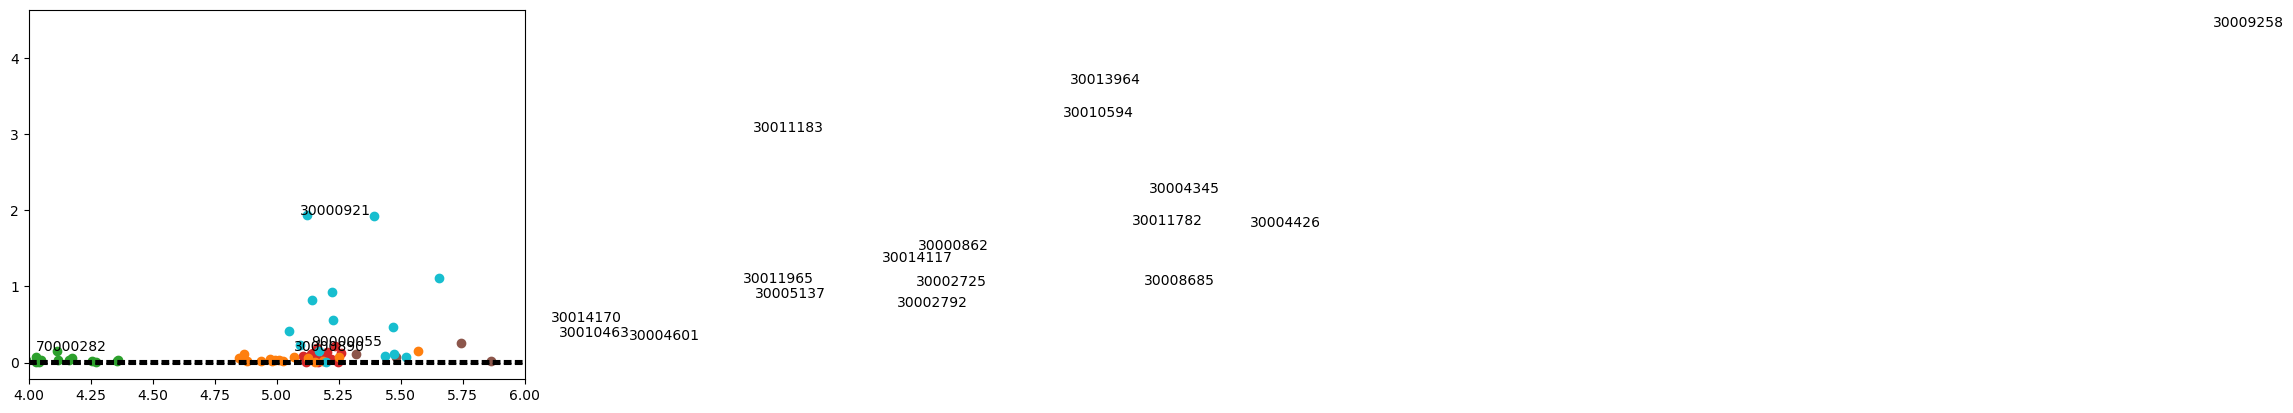

In [50]:
#Cycle through the files in this directory and plot the residuals

files = os.listdir()

mags = []
residuals = []
for f in files:
    if 'residuals' in f:
        print('----')
        if 'nogradient' in f:
            color = 'b'
            print('nogradient')
            continue

        else:
            color = 'r'
        residuals = pd.read_csv(f)

        plt.scatter(14 - 2.5*np.log10(residuals['sn_flux']), np.abs(residuals['mag_residual']), marker = 'o', label = str(residuals['id'][0]))
        plt.text(14 - 2.5*np.log10(residuals['sn_flux'][0]), np.max(np.abs(residuals['mag_residual'])), str(residuals['id'][0]))
        print(residuals['id'][0])
        print(np.mean(14 - 2.5*np.log10(residuals['sn_flux'])))
        print(np.std(residuals['mag_residual']))
        print(np.mean(residuals['mag_residual']))

#plt.legend()
plt.axhline(0, color = 'k', ls = '--')
plt.axhline(0.02, color = 'k', ls = '--')
plt.axhline(-0.02, color = 'k', ls = '--')
plt.xlim(4,6)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


nan nan
-0.036459645358412604 0.5454446413531584
(3, 705)
(681,)


/tmp/ipykernel_842150/2102318227.py:42: RuntimeWarning: Mean of empty slice
  print(np.nanmean(gradresiduals), np.nanstd(gradresiduals))
/hpc/home/cfm37/miniconda3/envs/ColeRoman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/hpc/home/cfm37/miniconda3/envs/ColeRoman/lib/python3.10/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/hpc/home/cfm37/miniconda3/envs/ColeRoman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


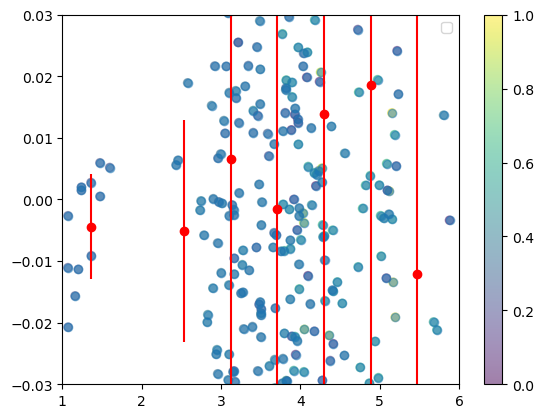

In [6]:
files = os.listdir()

gradresiduals = []
nogradresiduals = []
snflux = []
hostmag = []
hostsep = []
for f in files:
    if 'nogradient' in f:
        #or '.csv' not in f:
        residuals = pd.read_csv(f)
        nogradresiduals.extend(residuals['mag_residual'])
        snflux.extend(residuals['sn_flux'])
        hostmag.extend(residuals['host_mag_F'])
        hostsep.extend(residuals['host_sn_sep'])
    '''
        continue

    residuals = pd.read_csv(f)

    ID = f.split('_')[1].split('.')[0]

    try:
       residuals2 = pd.read_csv(f'residuals_nogradient_{ID}.csv')
    except:
        continue
    #print(residuals.columns)
    #plt.scatter(np.abs(residuals['mag_residual']), np.abs(residuals2['mag_residual']), marker = 'o', label = str(residuals['id'][0]))

    snflux.extend(residuals['sn_flux'])
    gradresiduals.extend(residuals['mag_residual'])
    nogradresiduals.extend(residuals2['mag_residual'])
    '''

bins = np.linspace(-1,1,50)
#plt.hist(gradresiduals, bins = bins, alpha = 0.5, label = 'With Gradient')
#plt.hist(nogradresiduals, bins = bins, alpha = 0.5, label = 'Without Gradient')
plt.legend()
mags = 14 - 2.5*np.log10(snflux)
plt.scatter(14-2.5*np.log10(snflux), nogradresiduals, marker = 'o', c= hostmag, alpha = 0.5)
plt.scatter(mags, nogradresiduals, marker = 'o', alpha = 0.5)
print(np.nanmean(gradresiduals), np.nanstd(gradresiduals))
print(np.nanmean(nogradresiduals), np.nanstd(nogradresiduals))



means, bins, _ = scipy.stats.binned_statistic(mags, nogradresiduals, statistic = np.nanmean, bins = 20)
stds, bins, _ = scipy.stats.binned_statistic(mags, nogradresiduals, statistic = np.nanstd, bins = 20)

bincenters = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(bincenters, means, yerr = stds, fmt = 'o', color = 'r')
plt.xlim(1,6)
plt.ylim(-0.03,0.03)
plt.colorbar()
#plt.yscale('symlog')
#plt.xscale('log')


#Scipy linear regression
from scipy import stats
x = np.array([mags, hostmag, hostsep])
print(np.shape(x))
y = np.array(nogradresiduals)

#remove rows with nans from x and y
mask = ~np.isnan(y)
x = x[:,mask].T
y = y[mask]

print(np.shape(y))


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x, y)

In [30]:
df = open_parq(10430, path = sn_path)
reals = df.loc[(df.peak_mjd < 62800.0)]
reals = reals.loc[(df.peak_mjd > 62400.0)]
reals = reals.loc[reals.host_mag_F < 999]
#reals = reals.loc[reals.ra > 6.487]
reals = reals.loc[reals.ra > 7]
#reals = reals.loc[reals.ra < 12.51]
reals = reals.loc[reals.ra < 8]
#reals = reals.loc[reals.dec > -46.877]
reals = reals.loc[reals.dec > -45]
#reals = reals.loc[reals.dec < -41.124]
reals = reals.loc[reals.dec < -44]
df = reals
print(df)
df = df.sort_values('host_mag_F', ascending=False)
maxloc = np.argmax(5*df['host_sn_sep'] + df['host_mag_F'] - df['peak_mag_F'])
print(df['id'].iloc[maxloc])

              id        ra        dec         host_id  gentype  \
1323    90000055  7.194761 -44.424092  10430200762122       58   
1339    70000282  7.599331 -44.434032  10430200669962       40   
1409    30000461  7.291559 -44.977996  10430100433335       32   
1419    30000714  7.376610 -44.495922  10430000492081       32   
1424    30000862  7.462903 -44.401654  10430100967073       32   
...          ...       ...        ...             ...      ...   
64726  110001506  7.088955 -44.424098  10430000449490       42   
64734  110001655  7.787660 -44.982086  10430000038874       42   
64765  110002167  7.742574 -44.728629  10430000296715       42   
64779  110002514  7.394897 -44.683098  10430100750249       42   
64788  110002642  7.748533 -44.343073  10430100130320       42   

                            model_name  start_mjd  end_mjd   z_CMB  mw_EBV  \
1323   NON1ASED.PISN-STELLA-HYDROGENIC    62456.0  63267.0  2.3147     0.0   
1339             NON1ASED.SLSN-I-BBFIT    62432.0  

In [ ]:
testimage = images[0*size**2:(0+1)*size**2].reshape(size,size)
stampsize = 11
not_done = True
model = np.zeros_like(testimage)
residual = testimage - model
psf_array = np.zeros((0,stampsize**2))
xes = []
ys = []
currentX = None
for i in range(5):
    #Place a psf grid model point at the point of maximum residual
    
    maxres = np.argsort(residual.flatten())[:3]
    print(maxres)
    #get the x and y of the max residual
    xres = maxres % size + np.random.uniform(-0.5,0.5,3) + 1
    yres = maxres // size + np.random.uniform(-0.5,0.5,3) + 1
    xes.append(xres)
    ys.append(yres)
    print('Max Residual', xres, yres)
    plt.subplot(1,2,1)
    plt.imshow(residual, origin = 'lower')
    #add a psf point there
    wcs = cutout_wcs_list[0]
    ra, dec = wcs.toWorld(xres, yres, units = 'deg')
    print(ra, dec)

    util_ref = roman_utils(config_file='./temp_tds.yaml', visit =exposures['Pointing'][0] , sca = exposures['SCA'][0])
    bpass= util_ref.bpass
    plt.subplot(1,2,2)
    psf = construct_psf_background(ra, dec, wcs, 2040,2040, stampsize, bpass, util_ref = util_ref)
    psf_array = np.append(psf, psf_array)
    psf_array = psf_array.reshape(stampsize**2, -1)
    #plt.imshow(psf.reshape(stampsize,stampsize), origin = 'lower')
    print(psf_array.shape)
    if currentX is None:
        initial_guess = np.zeros(psf_array.shape[1])
    else:
        initial_guess = np.concatenate([currentX,[0]])
        print(initial_guess)
    lsqr = sp.linalg.lsqr(np.array(psf_array), testimage.flatten(), atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10, x0 = initial_guess)
    print(lsqr[0])
    model = lsqr[0]*psf
    currentX = lsqr[0]
    model = np.sum(model, axis = 1)
    plt.imshow(testimage.reshape(stampsize,stampsize) - model.reshape(stampsize,stampsize), origin = 'lower')
    plt.scatter(np.array(xes) - 1, np.array(ys) - 1)
    plt.colorbar()
    plt.show()